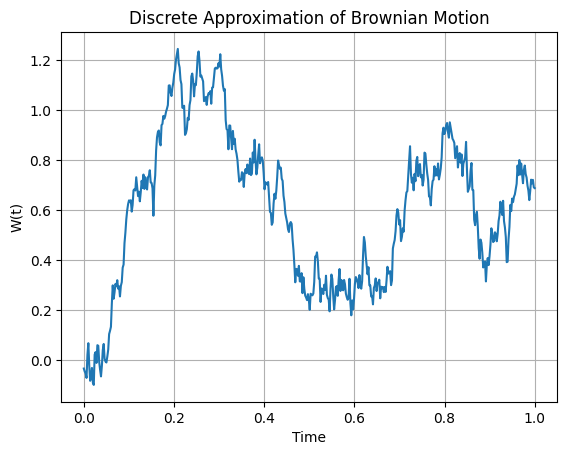

In [10]:
import numpy as np
import matplotlib.pyplot as plt

T = 1
N = 500
dt = T / N
t = np.linspace(0, T, N)
Z = np.random.normal(0, 1, N)
W = np.cumsum(np.sqrt(dt) * Z)  # Discrete Brownian motion

plt.plot(t, W)
plt.title("Discrete Approximation of Brownian Motion")
plt.xlabel("Time")
plt.ylabel("W(t)")
plt.grid(True)
plt.show()


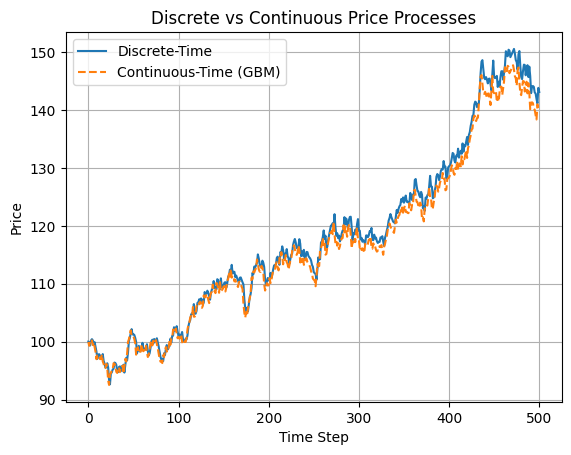

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100
T = 1
mu = 0.1
sigma = 0.2
N = 500
dt = T / N

# Discrete random walk
Z = np.random.normal(0, 1, N)
S_discrete = [S0]
for z in Z:
    S_discrete.append(S_discrete[-1] * np.exp(mu * dt + sigma * np.sqrt(dt) * z))

# Continuous approximation (Euler)
W = np.cumsum(np.sqrt(dt) * Z)
t = np.linspace(0, T, N)
S_continuous = S0 * np.exp((mu - 0.5 * sigma ** 2) * t + sigma * W)

# Plot
plt.plot(S_discrete, label='Discrete-Time')
plt.plot(S_continuous, label='Continuous-Time (GBM)', linestyle='--')
plt.legend()
plt.title("Discrete vs Continuous Price Processes")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.grid(True)
plt.show()


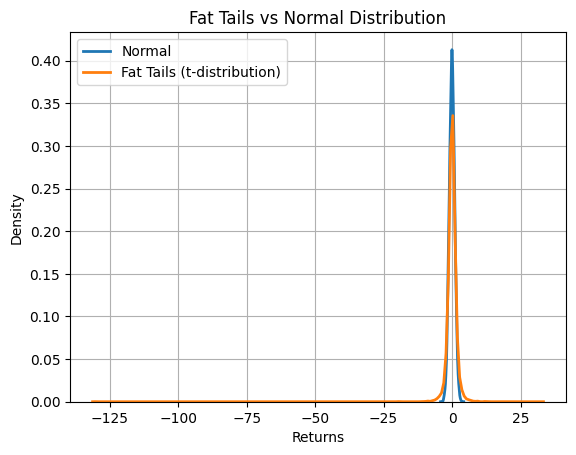

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
normal_returns = np.random.normal(0, 1, 10000)
fat_tailed_returns = np.random.standard_t(df=3, size=10000)  # t-distribution with fat tails

sns.kdeplot(normal_returns, label="Normal", linewidth=2)
sns.kdeplot(fat_tailed_returns, label="Fat Tails (t-distribution)", linewidth=2)
plt.title("Fat Tails vs Normal Distribution")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
S0 = 100
K = 100
u = 1.1
d = 0.9
r = 0.05
dt = 1
q = (np.exp(r * dt) - d) / (u - d)

# Final option values at T = 2
Suu = S0 * u * u
Sud = S0 * u * d
Sdd = S0 * d * d

Cu = max(Suu - K, 0)
Cm = max(Sud - K, 0)
Cd = max(Sdd - K, 0)

# Step back one level
C1u = np.exp(-r * dt) * (q * Cu + (1 - q) * Cm)
C1d = np.exp(-r * dt) * (q * Cm + (1 - q) * Cd)

# Step back to time 0
C0 = np.exp(-r * dt) * (q * C1u + (1 - q) * C1d)
print("Option Price:", round(C0, 2))


Option Price: 10.87


In [13]:
import numpy as np
import pandas as pd

# Parameters
S0 = 100          # Initial stock price
u = 1.1           # Up factor
d = 0.9           # Down factor
N = 3             # Number of time steps

# Initialize tree
tree = np.zeros((N+1, N+1))

# Fill the tree
for i in range(N+1):         # Time step
    for j in range(i+1):     # Number of up moves
        tree[i, j] = S0 * (u ** j) * (d ** (i - j))

# Convert to DataFrame for readability
df = pd.DataFrame(tree)
df = df.replace(0, "")
print("Binomial Asset Price Tree (N = 3):")
print(df)


Binomial Asset Price Tree (N = 3):
       0      1      2      3
0  100.0                     
1   90.0  110.0              
2   81.0   99.0  121.0       
3   72.9   89.1  108.9  133.1


In [14]:
import numpy as np

def crr_binomial_option_price(S0, K, T, r, sigma, N, option_type='call', exercise='european'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = np.exp(-sigma * np.sqrt(dt))
    p = (np.exp(r * dt) - d) / (u - d)

    # Step 1: Build asset price tree
    stock_tree = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            stock_tree[i, j] = S0 * (u ** j) * (d ** (i - j))
    
    # Step 2: Option value at maturity
    option_tree = np.zeros_like(stock_tree)
    for j in range(N + 1):
        if option_type == 'call':
            option_tree[N, j] = max(0, stock_tree[N, j] - K)
        else:
            option_tree[N, j] = max(0, K - stock_tree[N, j])
    
    # Step 3: Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            hold = np.exp(-r * dt) * (p * option_tree[i + 1, j + 1] + (1 - p) * option_tree[i + 1, j])
            if exercise == 'european':
                option_tree[i, j] = hold
            else:
                # American: check early exercise
                if option_type == 'call':
                    exercise_now = max(0, stock_tree[i, j] - K)
                else:
                    exercise_now = max(0, K - stock_tree[i, j])
                option_tree[i, j] = max(hold, exercise_now)
    
    return option_tree[0, 0]


In [15]:
S0 = 100     # Initial stock price
K = 100      # Strike
T = 1        # 1 year
r = 0.05     # 5% interest
sigma = 0.2  # 20% volatility
N = 100      # 100 steps

call_price = crr_binomial_option_price(S0, K, T, r, sigma, N, option_type='call', exercise='european')
put_price = crr_binomial_option_price(S0, K, T, r, sigma, N, option_type='put', exercise='european')

print(f"European Call Price: {call_price:.4f}")
print(f"European Put Price:  {put_price:.4f}")


European Call Price: 10.4306
European Put Price:  5.5536


In [16]:
import numpy as np

def binomial_option_price(S0, K, T, r, sigma, N, option_type="call"):
    """
    Price a European option using the Cox-Ross-Rubinstein (CRR) binomial model.

    Parameters:
    S0          = initial stock price
    K           = strike price
    T           = time to maturity (in years)
    r           = risk-free rate (annual, continuous compounding)
    sigma       = volatility (annual)
    N           = number of steps
    option_type = 'call' or 'put'

    Returns:
    Option price at t = 0
    """

    # Step size
    dt = T / N
    # Up and Down factors
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    # Risk-neutral probability
    p = (np.exp(r * dt) - d) / (u - d)

    # Stock prices at maturity
    ST = np.array([S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)])

    # Payoff at maturity
    if option_type == "call":
        payoff = np.maximum(ST - K, 0)
    elif option_type == "put":
        payoff = np.maximum(K - ST, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    # Backward induction
    discount = np.exp(-r * dt)
    for i in range(N - 1, -1, -1):
        payoff = discount * (p * payoff[1:] + (1 - p) * payoff[:-1])

    return payoff[0]


In [17]:
# Parameters
S0 = 100     # Initial stock price
K = 100      # Strike price
T = 1        # Time to maturity (1 year)
r = 0.05     # Risk-free rate (5%)
sigma = 0.2  # Volatility (20%)
N = 3        # Number of time steps

call_price = binomial_option_price(S0, K, T, r, sigma, N, option_type="call")
put_price  = binomial_option_price(S0, K, T, r, sigma, N, option_type="put")

print(f"European Call Option Price: {call_price:.4f}")
print(f"European Put Option Price:  {put_price:.4f}")


European Call Option Price: 11.0439
European Put Option Price:  6.1668


In [18]:
import numpy as np
from math import comb, exp

def arrow_debreu_prices(N, T, r, p):
    """
    Compute Arrow-Debreu security prices at maturity for each terminal node.

    Parameters:
    N = number of steps
    T = time to maturity
    r = risk-free rate (annual)
    p = risk-neutral probability

    Returns:
    List of Arrow-Debreu prices q_j for each node j
    """
    q = []
    discount = exp(-r * T)
    for j in range(N + 1):
        prob = comb(N, j) * (p ** j) * ((1 - p) ** (N - j))
        qj = discount * prob
        q.append(qj)
    return q


In [19]:
N = 3           # Number of steps
T = 1           # Maturity = 1 year
r = 0.05        # 5% risk-free rate
p = 0.5         # Risk-neutral probability (just an example)

q = arrow_debreu_prices(N, T, r, p)
for i, qj in enumerate(q):
    print(f"Arrow-Debreu price at node {i} (with {i} up-moves): {qj:.5f}")


Arrow-Debreu price at node 0 (with 0 up-moves): 0.11890
Arrow-Debreu price at node 1 (with 1 up-moves): 0.35671
Arrow-Debreu price at node 2 (with 2 up-moves): 0.35671
Arrow-Debreu price at node 3 (with 3 up-moves): 0.11890


In [20]:
payoffs = [5, 3, 1, 0]  # From node 0 to node 3


In [21]:
price = sum([qj * pj for qj, pj in zip(q, payoffs)])


In [22]:
print(payoffs)

[5, 3, 1, 0]


In [23]:
print(price)

2.021362527064017


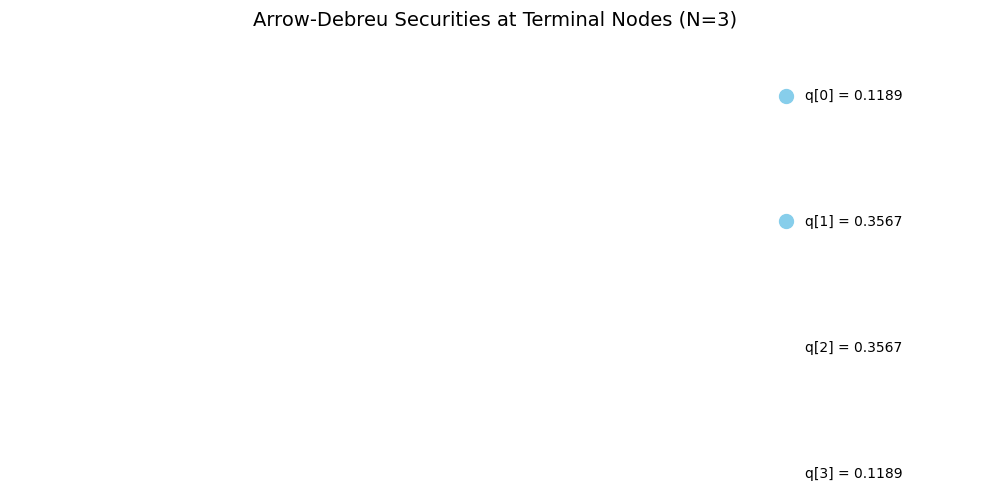

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from math import comb, exp

# Parameters
N = 3           # Number of steps
T = 1           # Time to maturity
r = 0.05        # Risk-free rate
p = 0.5         # Risk-neutral probability

# Compute Arrow-Debreu prices
def arrow_debreu_prices(N, T, r, p):
    q = []
    discount = exp(-r * T)
    for j in range(N + 1):
        prob = comb(N, j) * (p ** j) * ((1 - p) ** (N - j))
        qj = discount * prob
        q.append(qj)
    return q

q = arrow_debreu_prices(N, T, r, p)

# Plotting the binomial tree with Arrow-Debreu prices
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Arrow-Debreu Securities at Terminal Nodes (N=3)", fontsize=14)
ax.set_xlim(-1, N + 1)
ax.set_ylim(-0.5, N + 1)

# Draw nodes and values
for j in range(N + 1):
    x = N
    y = N - j * 2
    ax.plot(x, y, 'o', color='skyblue', markersize=10)
    ax.text(x + 0.1, y, f"q[{j}] = {q[j]:.4f}", fontsize=10, verticalalignment='center')

# Hide axes
ax.axis('off')

plt.tight_layout()
plt.show()


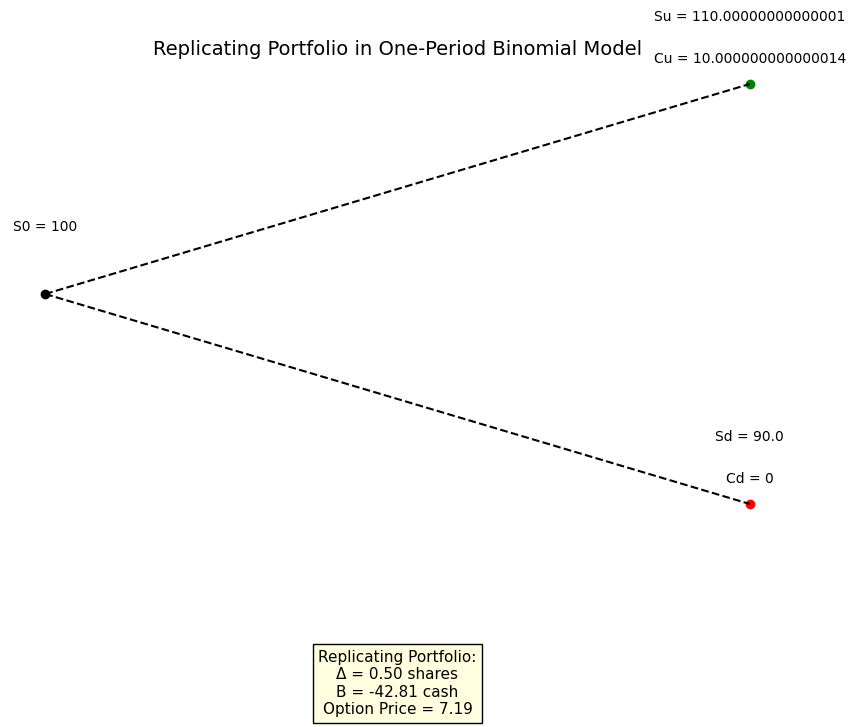

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100         # Initial stock price
K = 100          # Strike price
T = 1            # Time to maturity (in years)
r = 0.05         # Risk-free rate
u = 1.1          # Up factor
d = 0.9          # Down factor
N = 1            # One-period example
dt = T / N
R = np.exp(r * dt)

# Terminal stock prices
Su = S0 * u
Sd = S0 * d

# Terminal option payoffs for a call option
Cu = max(Su - K, 0)
Cd = max(Sd - K, 0)

# Calculate replicating portfolio
Delta = (Cu - Cd) / (Su - Sd)
B = (u * Cd - d * Cu) / (u - d) / R
C0 = Delta * S0 + B

# Visualization of Tree + Replicating Portfolio
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Replicating Portfolio in One-Period Binomial Model", fontsize=14)

# Draw nodes
ax.plot(0, 0, 'ko')
ax.text(0, 0.3, f"S0 = {S0}", ha='center', fontsize=10)

ax.plot(1, 1, 'go')
ax.text(1, 1.3, f"Su = {Su}", ha='center', fontsize=10)
ax.text(1, 1.1, f"Cu = {Cu}", ha='center', fontsize=10)

ax.plot(1, -1, 'ro')
ax.text(1, -0.7, f"Sd = {Sd}", ha='center', fontsize=10)
ax.text(1, -0.9, f"Cd = {Cd}", ha='center', fontsize=10)

# Connect nodes
ax.plot([0, 1], [0, 1], 'k--')
ax.plot([0, 1], [0, -1], 'k--')

# Show replicating portfolio
info_text = f"Replicating Portfolio:\nΔ = {Delta:.2f} shares\nB = {B:.2f} cash\nOption Price = {C0:.2f}"
ax.text(0.5, -2, info_text, ha='center', fontsize=11, bbox=dict(facecolor='lightyellow', edgecolor='black'))

# Hide axes
ax.axis('off')
plt.show()


In [27]:
import numpy as np

def binomial_option_pricing(S0, K, T, r, sigma, N, option_type="call", exercise="european"):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)
    
    # 1. Initialize asset prices at maturity
    asset_prices = np.array([S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)])
    
    # 2. Compute option payoff at maturity
    if option_type == "call":
        option_values = np.maximum(asset_prices - K, 0)
    else:
        option_values = np.maximum(K - asset_prices, 0)
    
    # 3. Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            # Expected discounted value
            hold = discount * (p * option_values[j + 1] + (1 - p) * option_values[j])
            
            if exercise == "european":
                option_values[j] = hold
            else:
                # Recalculate asset price at node (i, j)
                stock_price = S0 * (u ** j) * (d ** (i - j))
                if option_type == "call":
                    exercise_now = max(stock_price - K, 0)
                else:
                    exercise_now = max(K - stock_price, 0)
                option_values[j] = max(hold, exercise_now)
    
    return option_values[0]


In [28]:
# Parameters
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
N = 3

# Prices
euro_call = binomial_option_pricing(S0, K, T, r, sigma, N, "call", "european")
amer_call = binomial_option_pricing(S0, K, T, r, sigma, N, "call", "american")

euro_put  = binomial_option_pricing(S0, K, T, r, sigma, N, "put", "european")
amer_put  = binomial_option_pricing(S0, K, T, r, sigma, N, "put", "american")

print(f"European Call:  {euro_call:.4f}")
print(f"American Call:  {amer_call:.4f}")
print(f"European Put:   {euro_put:.4f}")
print(f"American Put:   {amer_put:.4f}")


European Call:  11.0439
American Call:  11.0439
European Put:   6.1668
American Put:   6.4996


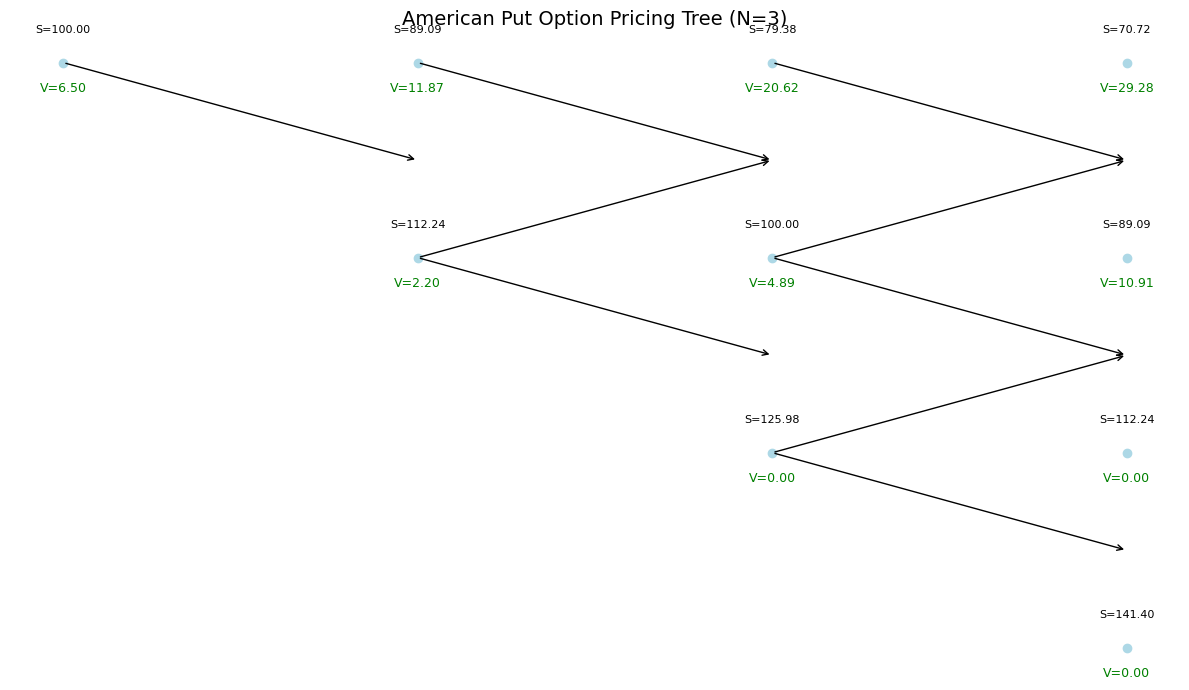

In [29]:
import matplotlib.pyplot as plt

def plot_binomial_tree(S0, K, T, r, sigma, N, option_type="call", exercise="european"):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)
    
    # Initialize asset and option trees
    stock_tree = [[S0 * (u ** j) * (d ** (i - j)) for j in range(i + 1)] for i in range(N + 1)]
    option_tree = [[0] * (i + 1) for i in range(N + 1)]

    # Terminal payoffs
    for j in range(N + 1):
        S = stock_tree[N][j]
        if option_type == "call":
            option_tree[N][j] = max(S - K, 0)
        else:
            option_tree[N][j] = max(K - S, 0)
    
    # Backward induction
    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            hold = discount * (p * option_tree[i + 1][j + 1] + (1 - p) * option_tree[i + 1][j])
            S = stock_tree[i][j]
            if exercise == "european":
                option_tree[i][j] = hold
            else:
                if option_type == "call":
                    exercise_now = max(S - K, 0)
                else:
                    exercise_now = max(K - S, 0)
                option_tree[i][j] = max(hold, exercise_now)

    # Plot tree
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.set_title(f"{exercise.capitalize()} {option_type.capitalize()} Option Pricing Tree (N={N})", fontsize=14)
    ax.axis("off")

    # Positioning
    x_spacing = 1
    y_spacing = 1

    for i in range(N + 1):
        for j in range(i + 1):
            x = i * x_spacing
            y = (N - 2 * j) * y_spacing
            ax.plot(x, y, 'o', color='lightblue')
            S_val = stock_tree[i][j]
            V_val = option_tree[i][j]
            ax.text(x, y + 0.3, f"S={S_val:.2f}", ha='center', fontsize=8)
            ax.text(x, y - 0.3, f"V={V_val:.2f}", ha='center', fontsize=9, color='green')

            # Draw arrows
            if i < N:
                up_y = (N - 2 * j - 1) * y_spacing
                down_y = (N - 2 * j + 1) * y_spacing
                ax.annotate("", xy=(x + x_spacing, up_y), xytext=(x, y),
                            arrowprops=dict(arrowstyle="->", lw=1))
                ax.annotate("", xy=(x + x_spacing, down_y), xytext=(x, y),
                            arrowprops=dict(arrowstyle="->", lw=1))

    plt.tight_layout()
    plt.show()

# Example: American Put Option Visualization
plot_binomial_tree(S0=100, K=100, T=1, r=0.05, sigma=0.2, N=3, option_type="put", exercise="american")


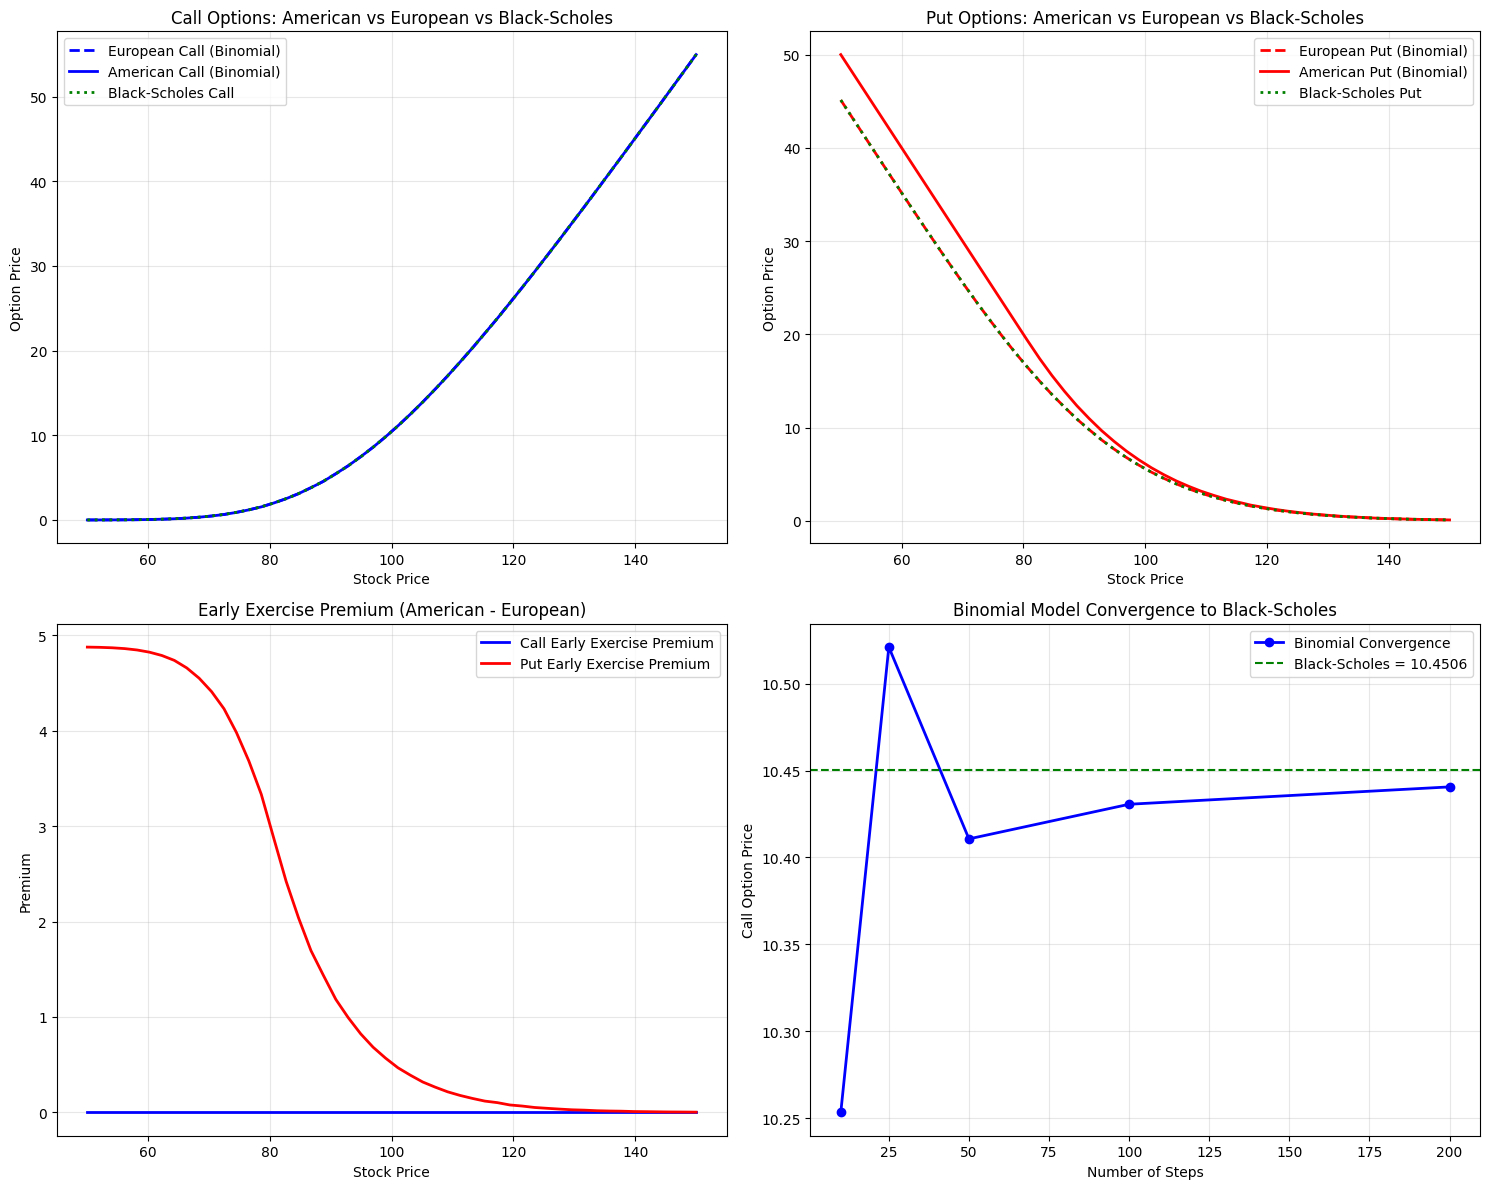

Option Pricing Comparison (S0=$100, K=$100)
European Call - Binomial: $11.1183
American Call - Binomial:  $11.1183
European Call - Black-Scholes: $11.1101
Call Early Exercise Premium: $0.0000

European Put - Binomial: $5.2208
American Put - Binomial:  $5.6889
European Put - Black-Scholes: $5.2126
Put Early Exercise Premium: $0.4681

Early Exercise Analysis for American Put:
Early exercise optimal for S0=$80
Number of early exercise nodes: 2693


In [31]:
import matplotlib.pyplot as plt
import numpy as np

def binomial_option_pricing(S0, K, T, r, sigma, N, option_type="call", exercise="european"):
    """
    Binomial option pricing model for European and American options
    
    Returns both the option price and early exercise boundary (for American options)
    """
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)
    
    # Store early exercise information
    early_exercise_boundary = []
    
    # Stock prices at maturity
    asset_prices = np.array([S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)])
    
    # Option payoffs at maturity
    if option_type == "call":
        option_values = np.maximum(asset_prices - K, 0)
    else:
        option_values = np.maximum(K - asset_prices, 0)

    # Backward induction
    for i in range(N - 1, -1, -1):
        new_option_values = np.zeros(i + 1)
        early_exercise_nodes = []
        
        for j in range(i + 1):
            hold = discount * (p * option_values[j + 1] + (1 - p) * option_values[j])
            
            if exercise == "european":
                new_option_values[j] = hold
            else:
                S = S0 * (u ** j) * (d ** (i - j))
                if option_type == "call":
                    exercise_now = max(S - K, 0)
                else:
                    exercise_now = max(K - S, 0)
                
                if exercise_now > hold:
                    new_option_values[j] = exercise_now
                    early_exercise_nodes.append((i * dt, S))
                else:
                    new_option_values[j] = hold
        
        option_values = new_option_values
        if early_exercise_nodes:
            early_exercise_boundary.extend(early_exercise_nodes)

    return option_values[0], early_exercise_boundary

# Black-Scholes formula for comparison
def black_scholes(S, K, T, r, sigma, option_type="call"):
    """Black-Scholes formula for European options"""
    from scipy.stats import norm
    
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type == "call":
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else:
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# Parameters
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
N = 100

# Compute option prices
stock_prices = np.linspace(50, 150, 50)

# Calculate all option prices
euro_call = []
amer_call = []
euro_put = []
amer_put = []
bs_call = []
bs_put = []

for S in stock_prices:
    ec, _ = binomial_option_pricing(S, K, T, r, sigma, N, "call", "european")
    ac, _ = binomial_option_pricing(S, K, T, r, sigma, N, "call", "american")
    ep, _ = binomial_option_pricing(S, K, T, r, sigma, N, "put", "european")
    ap, _ = binomial_option_pricing(S, K, T, r, sigma, N, "put", "american")
    
    euro_call.append(ec)
    amer_call.append(ac)
    euro_put.append(ep)
    amer_put.append(ap)
    bs_call.append(black_scholes(S, K, T, r, sigma, "call"))
    bs_put.append(black_scholes(S, K, T, r, sigma, "put"))

# Create comprehensive plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Call Options
ax1.plot(stock_prices, euro_call, 'b--', label='European Call (Binomial)', linewidth=2)
ax1.plot(stock_prices, amer_call, 'b-', label='American Call (Binomial)', linewidth=2)
ax1.plot(stock_prices, bs_call, 'g:', label='Black-Scholes Call', linewidth=2)
ax1.set_title('Call Options: American vs European vs Black-Scholes')
ax1.set_xlabel('Stock Price')
ax1.set_ylabel('Option Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Put Options
ax2.plot(stock_prices, euro_put, 'r--', label='European Put (Binomial)', linewidth=2)
ax2.plot(stock_prices, amer_put, 'r-', label='American Put (Binomial)', linewidth=2)
ax2.plot(stock_prices, bs_put, 'g:', label='Black-Scholes Put', linewidth=2)
ax2.set_title('Put Options: American vs European vs Black-Scholes')
ax2.set_xlabel('Stock Price')
ax2.set_ylabel('Option Price')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Early Exercise Premium
call_premium = np.array(amer_call) - np.array(euro_call)
put_premium = np.array(amer_put) - np.array(euro_put)

ax3.plot(stock_prices, call_premium, 'b-', label='Call Early Exercise Premium', linewidth=2)
ax3.plot(stock_prices, put_premium, 'r-', label='Put Early Exercise Premium', linewidth=2)
ax3.set_title('Early Exercise Premium (American - European)')
ax3.set_xlabel('Stock Price')
ax3.set_ylabel('Premium')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Convergence Analysis
steps = [10, 25, 50, 100, 200]
binomial_prices = []
for n in steps:
    price, _ = binomial_option_pricing(S0, K, T, r, sigma, n, "call", "european")
    binomial_prices.append(price)

bs_price = black_scholes(S0, K, T, r, sigma, "call")
ax4.plot(steps, binomial_prices, 'bo-', label='Binomial Convergence', linewidth=2)
ax4.axhline(y=bs_price, color='g', linestyle='--', label=f'Black-Scholes = {bs_price:.4f}')
ax4.set_title('Binomial Model Convergence to Black-Scholes')
ax4.set_xlabel('Number of Steps')
ax4.set_ylabel('Call Option Price')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print numerical comparison
print("Option Pricing Comparison (S0=$100, K=$100)")
print("=" * 50)
print(f"European Call - Binomial: ${euro_call[25]:.4f}")
print(f"American Call - Binomial:  ${amer_call[25]:.4f}")
print(f"European Call - Black-Scholes: ${bs_call[25]:.4f}")
print(f"Call Early Exercise Premium: ${amer_call[25] - euro_call[25]:.4f}")
print()
print(f"European Put - Binomial: ${euro_put[25]:.4f}")
print(f"American Put - Binomial:  ${amer_put[25]:.4f}")
print(f"European Put - Black-Scholes: ${bs_put[25]:.4f}")
print(f"Put Early Exercise Premium: ${amer_put[25] - euro_put[25]:.4f}")

# Analyze early exercise boundary for American put
print("\nEarly Exercise Analysis for American Put:")
print("=" * 40)
_, early_exercise = binomial_option_pricing(80, K, T, r, sigma, N, "put", "american")
if early_exercise:
    print(f"Early exercise optimal for S0=$80")
    print(f"Number of early exercise nodes: {len(early_exercise)}")
else:
    print("No early exercise optimal for S0=$80")

ValueError: Integers to negative integer powers are not allowed.

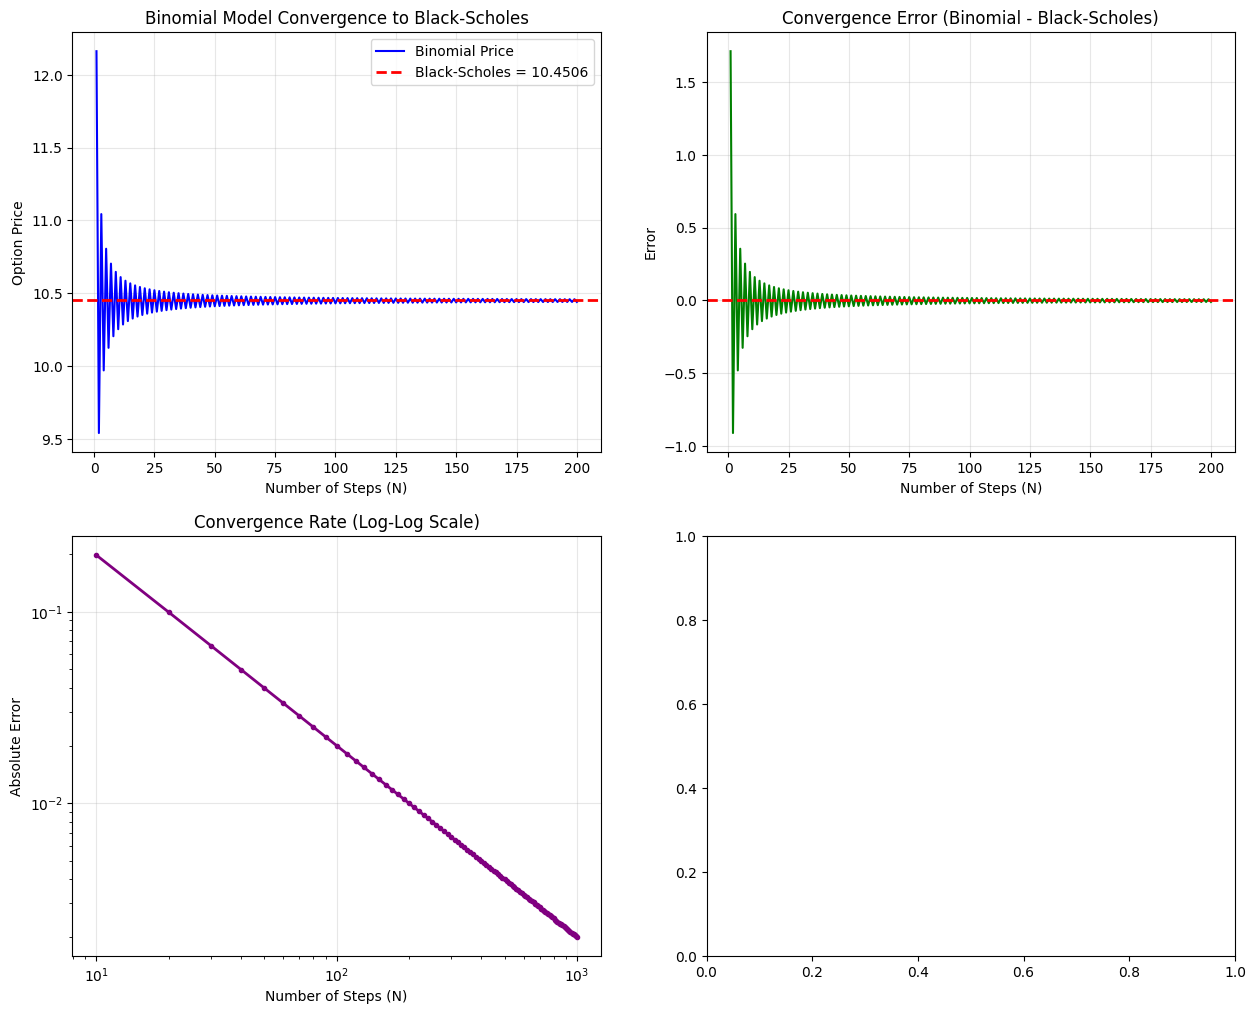

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula for European call
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# Binomial model for European call option
def binomial_call(S, K, T, r, sigma, N):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    discount = np.exp(-r * dt)
    
    # Terminal prices
    asset_prices = np.array([S * (u ** j) * (d ** (N - j)) for j in range(N + 1)])
    option_values = np.maximum(asset_prices - K, 0)
    
    # Backward induction
    for i in range(N - 1, -1, -1):
        option_values = discount * (p * option_values[1:i+2] + (1 - p) * option_values[0:i+1])
    
    return option_values[0]

# Parameters
S = 100
K = 100
T = 1
r = 0.05
sigma = 0.2

# Calculate Black-Scholes price
bs_price = black_scholes_call(S, K, T, r, sigma)

# Create comprehensive analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Basic Convergence
steps = np.arange(1, 201)
binomial_prices = [binomial_call(S, K, T, r, sigma, N) for N in steps]

ax1.plot(steps, binomial_prices, 'b-', linewidth=1.5, label='Binomial Price')
ax1.axhline(bs_price, color='red', linestyle='--', linewidth=2, 
           label=f'Black-Scholes = {bs_price:.4f}')
ax1.set_title('Binomial Model Convergence to Black-Scholes')
ax1.set_xlabel('Number of Steps (N)')
ax1.set_ylabel('Option Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Convergence Error
errors = np.array(binomial_prices) - bs_price
ax2.plot(steps, errors, 'g-', linewidth=1.5)
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.set_title('Convergence Error (Binomial - Black-Scholes)')
ax2.set_xlabel('Number of Steps (N)')
ax2.set_ylabel('Error')
ax2.grid(True, alpha=0.3)

# Plot 3: Log-scale convergence (for large N)
large_steps = np.arange(10, 1001, 10)
large_binomial_prices = [binomial_call(S, K, T, r, sigma, N) for N in large_steps]
large_errors = np.abs(np.array(large_binomial_prices) - bs_price)

ax3.loglog(large_steps, large_errors, 'purple', linewidth=2, marker='o', markersize=3)
ax3.set_title('Convergence Rate (Log-Log Scale)')
ax3.set_xlabel('Number of Steps (N)')
ax3.set_ylabel('Absolute Error')
ax3.grid(True, alpha=0.3)

# Add theoretical convergence rate line
theoretical_slope = large_steps**(-1)
theoretical_slope = theoretical_slope * (large_errors[0] / theoretical_slope[0])
ax3.loglog(large_steps, theoretical_slope, 'r--', linewidth=2, 
          label='O(1/N) theoretical rate')
ax3.legend()

# Plot 4: Oscillating behavior for small N
small_steps = np.arange(1, 51)
small_binomial_prices = [binomial_call(S, K, T, r, sigma, N) for N in small_steps]

ax4.plot(small_steps, small_binomial_prices, 'b-', linewidth=1.5, 
         marker='o', markersize=4, label='Binomial Price')
ax4.axhline(bs_price, color='red', linestyle='--', linewidth=2, 
           label=f'Black-Scholes = {bs_price:.4f}')
ax4.set_title('Oscillating Convergence (Small N)')
ax4.set_xlabel('Number of Steps (N)')
ax4.set_ylabel('Option Price')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Numerical analysis
print("Binomial to Black-Scholes Convergence Analysis")
print("=" * 50)
print(f"Black-Scholes Price: ${bs_price:.6f}")
print()

# Show convergence at specific points
test_points = [10, 25, 50, 100, 200, 500, 1000]
print("Convergence at specific points:")
print("-" * 35)
for n in test_points:
    bin_price = binomial_call(S, K, T, r, sigma, n)
    error = bin_price - bs_price
    print(f"N={n:4d}: Price=${bin_price:.6f}, Error={error:+.6f}")

# Analyze oscillation pattern
print("\nOscillation Analysis (first 20 steps):")
print("-" * 40)
for n in range(1, 21):
    bin_price = binomial_call(S, K, T, r, sigma, n)
    error = bin_price - bs_price
    direction = "Above" if error > 0 else "Below"
    print(f"N={n:2d}: ${bin_price:.4f} ({direction} BS by {abs(error):.4f})")

# Calculate convergence statistics
final_100_errors = np.array([binomial_call(S, K, T, r, sigma, n) - bs_price 
                            for n in range(901, 1001)])
print(f"\nConvergence Statistics (N=901-1000):")
print(f"Mean absolute error: {np.mean(np.abs(final_100_errors)):.6f}")
print(f"Standard deviation: {np.std(final_100_errors):.6f}")
print(f"Max absolute error: {np.max(np.abs(final_100_errors)):.6f}")

# Show computational efficiency
import time
print(f"\nComputational Efficiency:")
print("-" * 25)
for n in [100, 500, 1000]:
    start_time = time.time()
    price = binomial_call(S, K, T, r, sigma, n)
    end_time = time.time()
    error = abs(price - bs_price)
    print(f"N={n:4d}: Time={end_time-start_time:.4f}s, Error={error:.6f}")

# Black-Scholes computation time
start_time = time.time()
bs_price_timed = black_scholes_call(S, K, T, r, sigma)
end_time = time.time()
print(f"Black-Scholes: Time={end_time-start_time:.6f}s (analytical solution)")

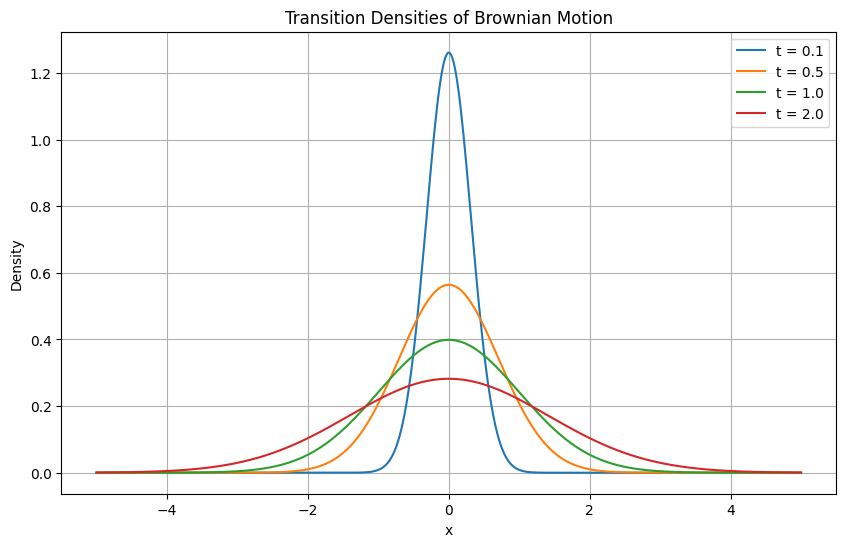

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set up Brownian Motion Parameters
x0 = 0          # initial position
sigma = 1       # volatility
times = [0.1, 0.5, 1.0, 2.0]  # different time horizons
x_vals = np.linspace(-5, 5, 500)  # range of x for plotting

# Plot transition density for Brownian motion
plt.figure(figsize=(10, 6))
for t in times:
    density = norm.pdf(x_vals, loc=x0, scale=np.sqrt(sigma**2 * t))
    plt.plot(x_vals, density, label=f"t = {t}")

plt.title("Transition Densities of Brownian Motion")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


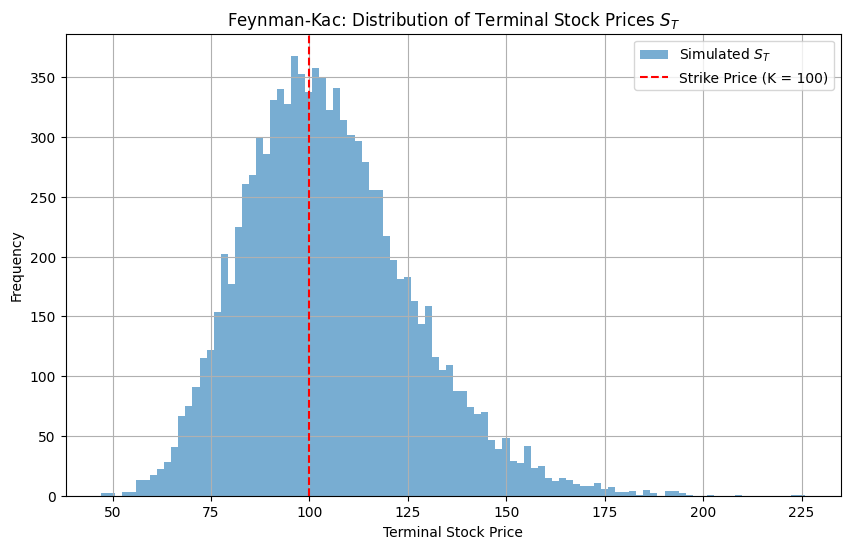

np.float64(10.450169921134655)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for Geometric Brownian Motion
S0 = 100      # initial stock price
K = 100       # strike price
r = 0.05      # risk-free rate
sigma = 0.2   # volatility
T = 1.0       # time to maturity
n_sim = 10000  # number of Monte Carlo simulations

# Simulate GBM paths
np.random.seed(42)
Z = np.random.randn(n_sim)
ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

# European Call Option payoff
payoff = np.maximum(ST - K, 0)

# Feynman-Kac pricing: expected discounted payoff
call_price = np.exp(-r * T) * np.mean(payoff)

# Plot histogram of terminal stock prices and payoff region
plt.figure(figsize=(10, 6))
plt.hist(ST, bins=100, alpha=0.6, label="Simulated $S_T$")
plt.axvline(K, color='red', linestyle='--', label=f"Strike Price (K = {K})")
plt.title("Feynman-Kac: Distribution of Terminal Stock Prices $S_T$")
plt.xlabel("Terminal Stock Price")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

call_price


=== Feynman-Kac Theorem Demonstration ===

1. BLACK-SCHOLES OPTION PRICING
----------------------------------------
Call Option:
  Analytical (Black-Scholes): $10.4506
  Feynman-Kac (Monte Carlo): $10.3994
  Error: 0.0512

Put Option:
  Analytical (Black-Scholes): $5.5735
  Feynman-Kac (Monte Carlo): $5.5993
  Error: 0.0258

2. HEAT EQUATION SOLUTION
----------------------------------------
Heat equation at x=0.5, t=0.1:
  Analytical solution: 0.851044
  Feynman-Kac solution: 0.852250
  Error: 0.001206

FEYNMAN-KAC THEOREM - EDUCATIONAL SUMMARY

The Feynman-Kac theorem provides a powerful connection between:
1. Partial Differential Equations (PDEs)
2. Stochastic Processes
3. Expected Values

KEY INSIGHT:
Solutions to certain PDEs can be represented as expectations
of functionals of stochastic processes.

MATHEMATICAL FORMULATION:
For PDE: ∂u/∂t + Lu - ru + f = 0
where L is a differential operator

Solution: u(t,x) = E[e^(-r(T-t)) * g(X_T) + ∫[t→T] e^(-r(s-t)) * f(X_s) ds]

APPLICATIONS

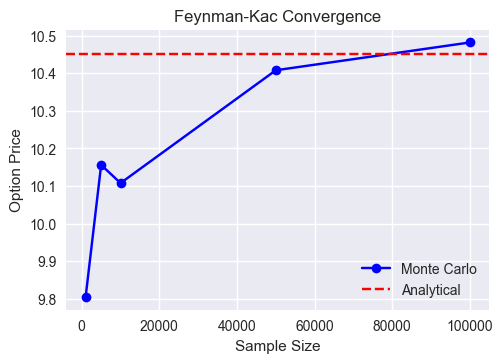

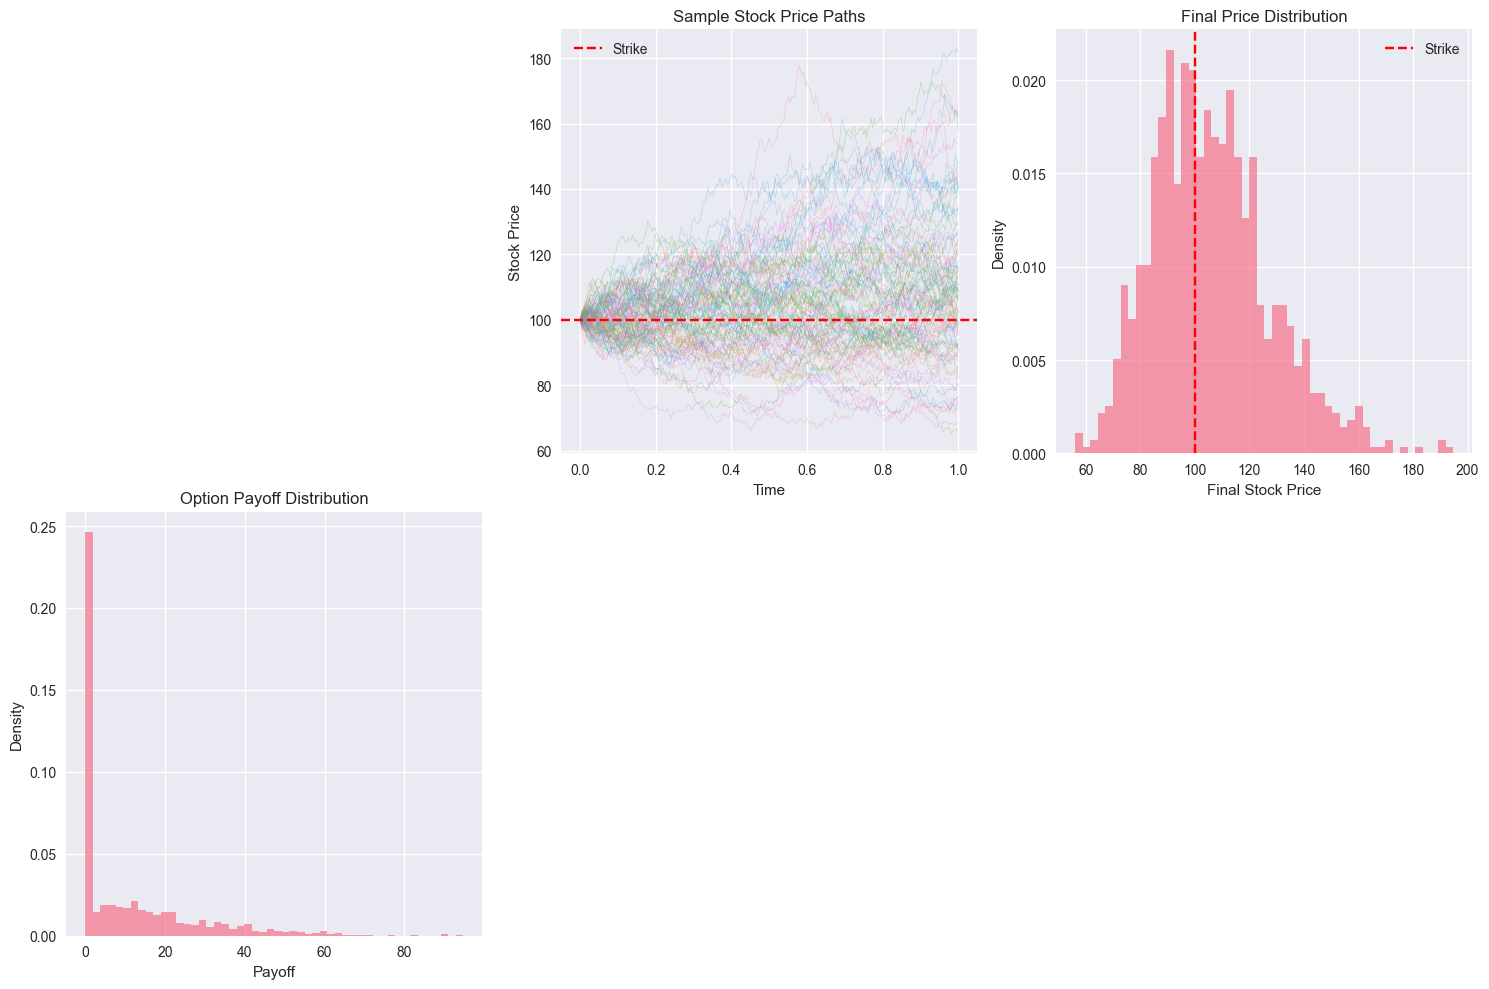

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import seaborn as sns

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class FeynmanKacDemo:
    """
    Demonstrates the Feynman-Kac theorem through various examples.
    
    The Feynman-Kac theorem states that under certain conditions,
    the solution to a PDE can be represented as an expectation
    of a functional of a stochastic process.
    
    For a PDE: ∂u/∂t + (1/2)σ²∂²u/∂x² + μ∂u/∂x - ru + f = 0
    with final condition u(T,x) = g(x)
    
    The solution is: u(t,x) = E[e^(-r(T-t)) * g(X_T) + ∫[t to T] e^(-r(s-t)) * f(X_s) ds]
    where X follows: dX = μ dt + σ dW
    """
    
    def __init__(self):
        self.random_seed = 42
        np.random.seed(self.random_seed)
    
    def simulate_geometric_brownian_motion(self, S0, mu, sigma, T, N, M):
        """
        Simulate M paths of Geometric Brownian Motion with N time steps
        
        dS = μS dt + σS dW
        
        Parameters:
        - S0: initial value
        - mu: drift parameter
        - sigma: volatility parameter
        - T: time horizon
        - N: number of time steps
        - M: number of paths
        """
        dt = T / N
        t = np.linspace(0, T, N + 1)
        
        # Generate random increments
        dW = np.random.normal(0, np.sqrt(dt), (M, N))
        
        # Initialize paths
        S = np.zeros((M, N + 1))
        S[:, 0] = S0
        
        # Simulate paths using exact solution
        for i in range(1, N + 1):
            S[:, i] = S[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[:, i-1])
        
        return t, S
    
    def black_scholes_analytical(self, S0, K, T, r, sigma, option_type='call'):
        """
        Analytical Black-Scholes solution for European options
        """
        d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        
        if option_type == 'call':
            price = S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
        else:  # put
            price = K * np.exp(-r*T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
        
        return price
    
    def feynman_kac_option_pricing(self, S0, K, T, r, sigma, M=100000, option_type='call'):
        """
        Price European option using Feynman-Kac representation
        
        The Black-Scholes PDE:
        ∂V/∂t + (1/2)σ²S²∂²V/∂S² + rS∂V/∂S - rV = 0
        
        Has Feynman-Kac representation:
        V(t,S) = E[e^(-r(T-t)) * payoff(S_T)]
        """
        # Simulate stock price paths
        t, S_paths = self.simulate_geometric_brownian_motion(S0, r, sigma, T, 252, M)
        
        # Calculate payoffs at maturity
        S_T = S_paths[:, -1]
        if option_type == 'call':
            payoffs = np.maximum(S_T - K, 0)
        else:  # put
            payoffs = np.maximum(K - S_T, 0)
        
        # Apply discount factor and take expectation
        option_price = np.exp(-r * T) * np.mean(payoffs)
        
        return option_price, S_paths
    
    def heat_equation_feynman_kac(self, x0, T, sigma=1.0, M=50000):
        """
        Solve heat equation using Feynman-Kac
        
        PDE: ∂u/∂t - (1/2)σ²∂²u/∂x² = 0
        Initial condition: u(0,x) = e^(-x²/2)
        
        Feynman-Kac: u(t,x) = E[u(0, X_t)] where dX = σ dW
        """
        # Simulate Brownian motion paths
        dt = T / 252
        dW = np.random.normal(0, np.sqrt(dt), (M, 252))
        
        # Initialize paths
        X = np.zeros((M, 253))
        X[:, 0] = x0
        
        # Simulate paths
        for i in range(1, 253):
            X[:, i] = X[:, i-1] + sigma * dW[:, i-1]
        
        # Apply initial condition at final time
        final_values = np.exp(-X[:, -1]**2 / 2)
        
        # Feynman-Kac expectation
        mc_solution = np.mean(final_values)
        
        # Analytical solution for comparison
        analytical_solution = (1/np.sqrt(1 + sigma**2 * T)) * np.exp(-x0**2 / (2 * (1 + sigma**2 * T)))
        
        return mc_solution, analytical_solution, X
    
    def demonstrate_convergence(self):
        """
        Demonstrate Monte Carlo convergence for Feynman-Kac
        """
        # Parameters
        S0, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
        
        # Different sample sizes
        sample_sizes = [1000, 5000, 10000, 50000, 100000]
        mc_prices = []
        
        analytical_price = self.black_scholes_analytical(S0, K, T, r, sigma)
        
        for M in sample_sizes:
            price, _ = self.feynman_kac_option_pricing(S0, K, T, r, sigma, M)
            mc_prices.append(price)
        
        # Plot convergence
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        plt.plot(sample_sizes, mc_prices, 'bo-', label='Monte Carlo')
        plt.axhline(y=analytical_price, color='r', linestyle='--', label='Analytical')
        plt.xlabel('Sample Size')
        plt.ylabel('Option Price')
        plt.title('Feynman-Kac Convergence')
        plt.legend()
        plt.grid(True)
        
        return sample_sizes, mc_prices, analytical_price
    
    def visualize_paths_and_payoffs(self):
        """
        Visualize stock paths and option payoffs
        """
        S0, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
        
        # Generate paths
        price, paths = self.feynman_kac_option_pricing(S0, K, T, r, sigma, M=1000)
        t = np.linspace(0, T, 253)
        
        plt.figure(figsize=(15, 10))
        
        # Plot sample paths
        plt.subplot(2, 3, 2)
        for i in range(min(100, len(paths))):
            plt.plot(t, paths[i], alpha=0.3, linewidth=0.5)
        plt.axhline(y=K, color='r', linestyle='--', label='Strike')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.title('Sample Stock Price Paths')
        plt.legend()
        plt.grid(True)
        
        # Plot final distribution
        plt.subplot(2, 3, 3)
        plt.hist(paths[:, -1], bins=50, alpha=0.7, density=True)
        plt.axvline(x=K, color='r', linestyle='--', label='Strike')
        plt.xlabel('Final Stock Price')
        plt.ylabel('Density')
        plt.title('Final Price Distribution')
        plt.legend()
        plt.grid(True)
        
        # Plot payoff distribution
        plt.subplot(2, 3, 4)
        payoffs = np.maximum(paths[:, -1] - K, 0)
        plt.hist(payoffs, bins=50, alpha=0.7, density=True)
        plt.xlabel('Payoff')
        plt.ylabel('Density')
        plt.title('Option Payoff Distribution')
        plt.grid(True)
        
        return paths, payoffs
    
    def compare_methods(self):
        """
        Compare Feynman-Kac with analytical solutions
        """
        print("=== Feynman-Kac Theorem Demonstration ===\n")
        
        # Option pricing comparison
        print("1. BLACK-SCHOLES OPTION PRICING")
        print("-" * 40)
        
        S0, K, T, r, sigma = 100, 100, 1.0, 0.05, 0.2
        
        analytical_call = self.black_scholes_analytical(S0, K, T, r, sigma, 'call')
        analytical_put = self.black_scholes_analytical(S0, K, T, r, sigma, 'put')
        
        mc_call, _ = self.feynman_kac_option_pricing(S0, K, T, r, sigma, M=100000, option_type='call')
        mc_put, _ = self.feynman_kac_option_pricing(S0, K, T, r, sigma, M=100000, option_type='put')
        
        print(f"Call Option:")
        print(f"  Analytical (Black-Scholes): ${analytical_call:.4f}")
        print(f"  Feynman-Kac (Monte Carlo): ${mc_call:.4f}")
        print(f"  Error: {abs(analytical_call - mc_call):.4f}")
        
        print(f"\nPut Option:")
        print(f"  Analytical (Black-Scholes): ${analytical_put:.4f}")
        print(f"  Feynman-Kac (Monte Carlo): ${mc_put:.4f}")
        print(f"  Error: {abs(analytical_put - mc_put):.4f}")
        
        # Heat equation comparison
        print(f"\n2. HEAT EQUATION SOLUTION")
        print("-" * 40)
        
        x0, T_heat = 0.5, 0.1
        mc_heat, analytical_heat, _ = self.heat_equation_feynman_kac(x0, T_heat)
        
        print(f"Heat equation at x={x0}, t={T_heat}:")
        print(f"  Analytical solution: {analytical_heat:.6f}")
        print(f"  Feynman-Kac solution: {mc_heat:.6f}")
        print(f"  Error: {abs(analytical_heat - mc_heat):.6f}")
        
        return {
            'option_results': {
                'analytical_call': analytical_call,
                'mc_call': mc_call,
                'analytical_put': analytical_put,
                'mc_put': mc_put
            },
            'heat_results': {
                'analytical': analytical_heat,
                'mc': mc_heat
            }
        }
    
    def educational_summary(self):
        """
        Print educational summary of Feynman-Kac theorem
        """
        print("\n" + "="*60)
        print("FEYNMAN-KAC THEOREM - EDUCATIONAL SUMMARY")
        print("="*60)
        
        print("""
The Feynman-Kac theorem provides a powerful connection between:
1. Partial Differential Equations (PDEs)
2. Stochastic Processes
3. Expected Values

KEY INSIGHT:
Solutions to certain PDEs can be represented as expectations
of functionals of stochastic processes.

MATHEMATICAL FORMULATION:
For PDE: ∂u/∂t + Lu - ru + f = 0
where L is a differential operator

Solution: u(t,x) = E[e^(-r(T-t)) * g(X_T) + ∫[t→T] e^(-r(s-t)) * f(X_s) ds]

APPLICATIONS DEMONSTRATED:
1. Option Pricing (Black-Scholes PDE → Monte Carlo simulation)
2. Heat Equation (Diffusion PDE → Brownian motion expectation)

ADVANTAGES:
- Transforms difficult PDEs into Monte Carlo problems
- Provides intuitive probabilistic interpretation
- Handles high-dimensional problems effectively
- Allows for complex boundary conditions

COMPUTATIONAL APPROACH:
1. Identify the underlying stochastic process
2. Simulate many paths of the process
3. Evaluate the functional for each path
4. Take the average (expectation)
        """)

def main():
    """
    Main demonstration of Feynman-Kac theorem
    """
    demo = FeynmanKacDemo()
    
    # Run comparisons
    results = demo.compare_methods()
    
    # Show convergence
    demo.demonstrate_convergence()
    
    # Visualize paths and payoffs
    demo.visualize_paths_and_payoffs()
    
    # Educational summary
    demo.educational_summary()
    
    # Show all plots
    plt.tight_layout()
    plt.show()
    
    return results

if __name__ == "__main__":
    results = main()

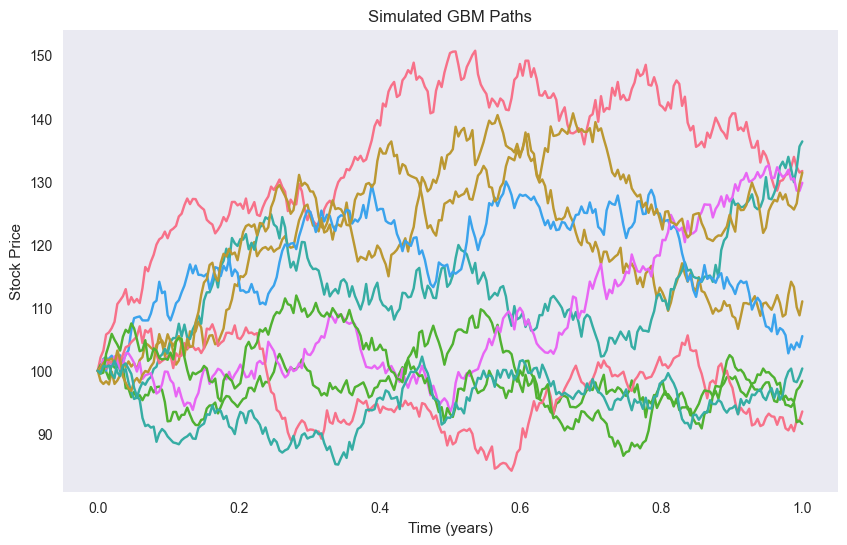

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gbm(S0, mu, sigma, T, N, M):
    dt = T / N
    t = np.linspace(0, T, N+1)
    paths = np.zeros((M, N+1))
    paths[:, 0] = S0

    for i in range(1, N+1):
        Z = np.random.normal(size=M)
        paths[:, i] = paths[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return t, paths

# Parameters
S0 = 100
mu = 0.1
sigma = 0.2
T = 1.0
N = 252
M = 10

t, paths = simulate_gbm(S0, mu, sigma, T, N, M)

plt.figure(figsize=(10, 6))
for i in range(M):
    plt.plot(t, paths[i])
plt.title("Simulated GBM Paths")
plt.xlabel("Time (years)")
plt.ylabel("Stock Price")
plt.grid()
plt.show()


Forward Kolmogorov Equation Demonstration

1. Brownian Motion
Solving Forward Kolmogorov for Brownian Motion...

2. Ornstein-Uhlenbeck Process
Solving Forward Kolmogorov for Ornstein-Uhlenbeck...

3. Geometric Brownian Motion
Solving Forward Kolmogorov for Geometric Brownian Motion...

4. Visualizing Solutions...


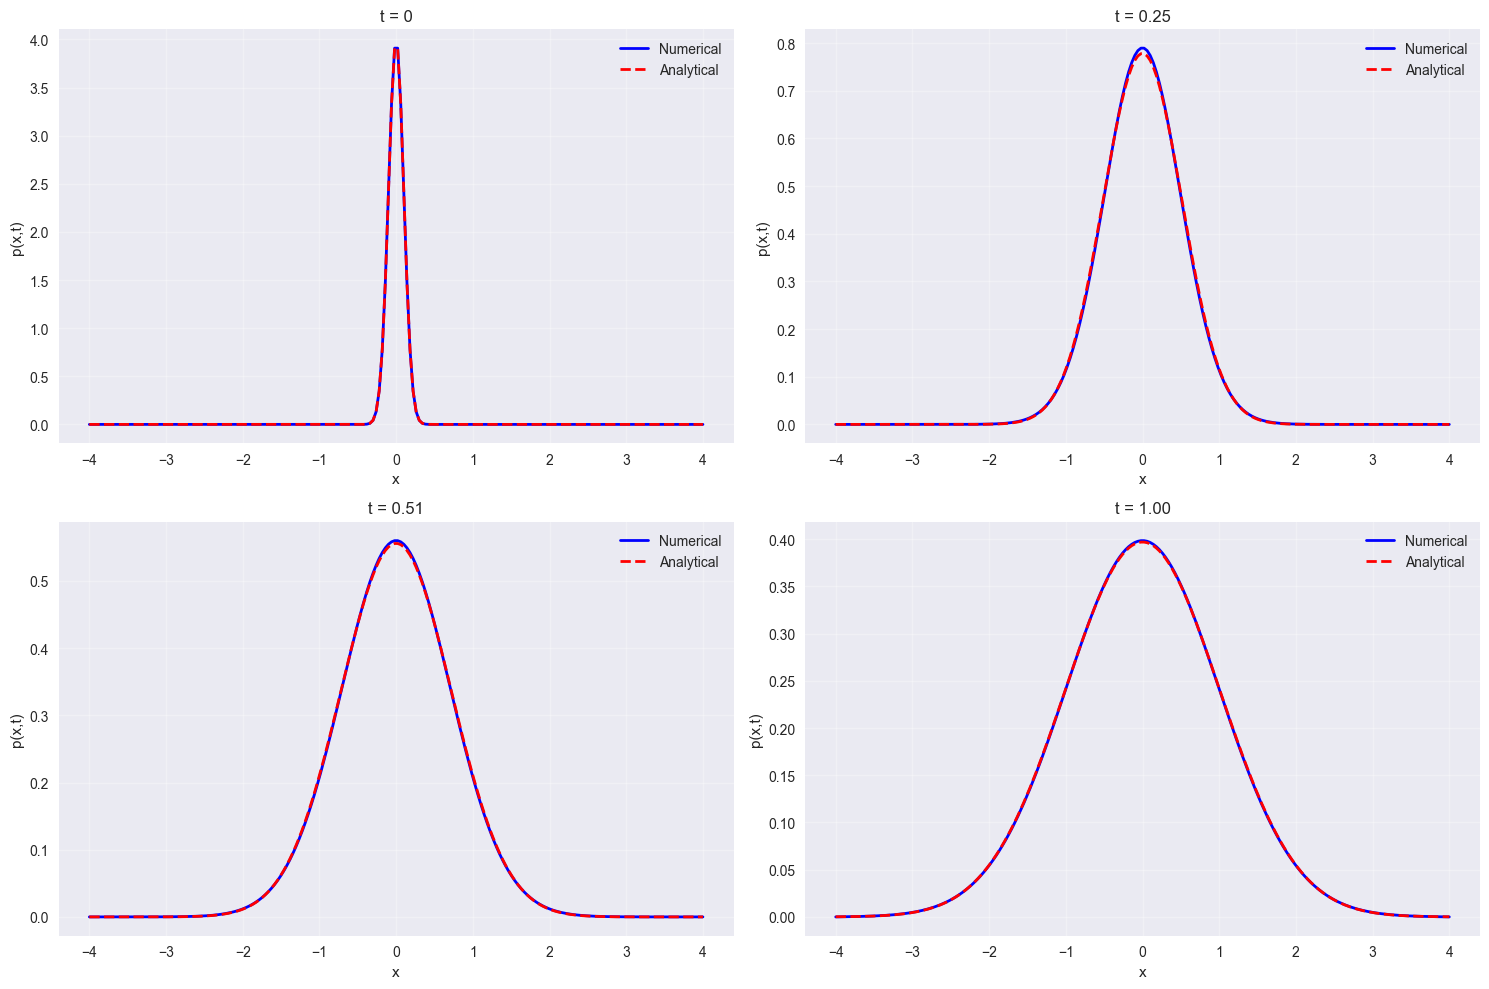

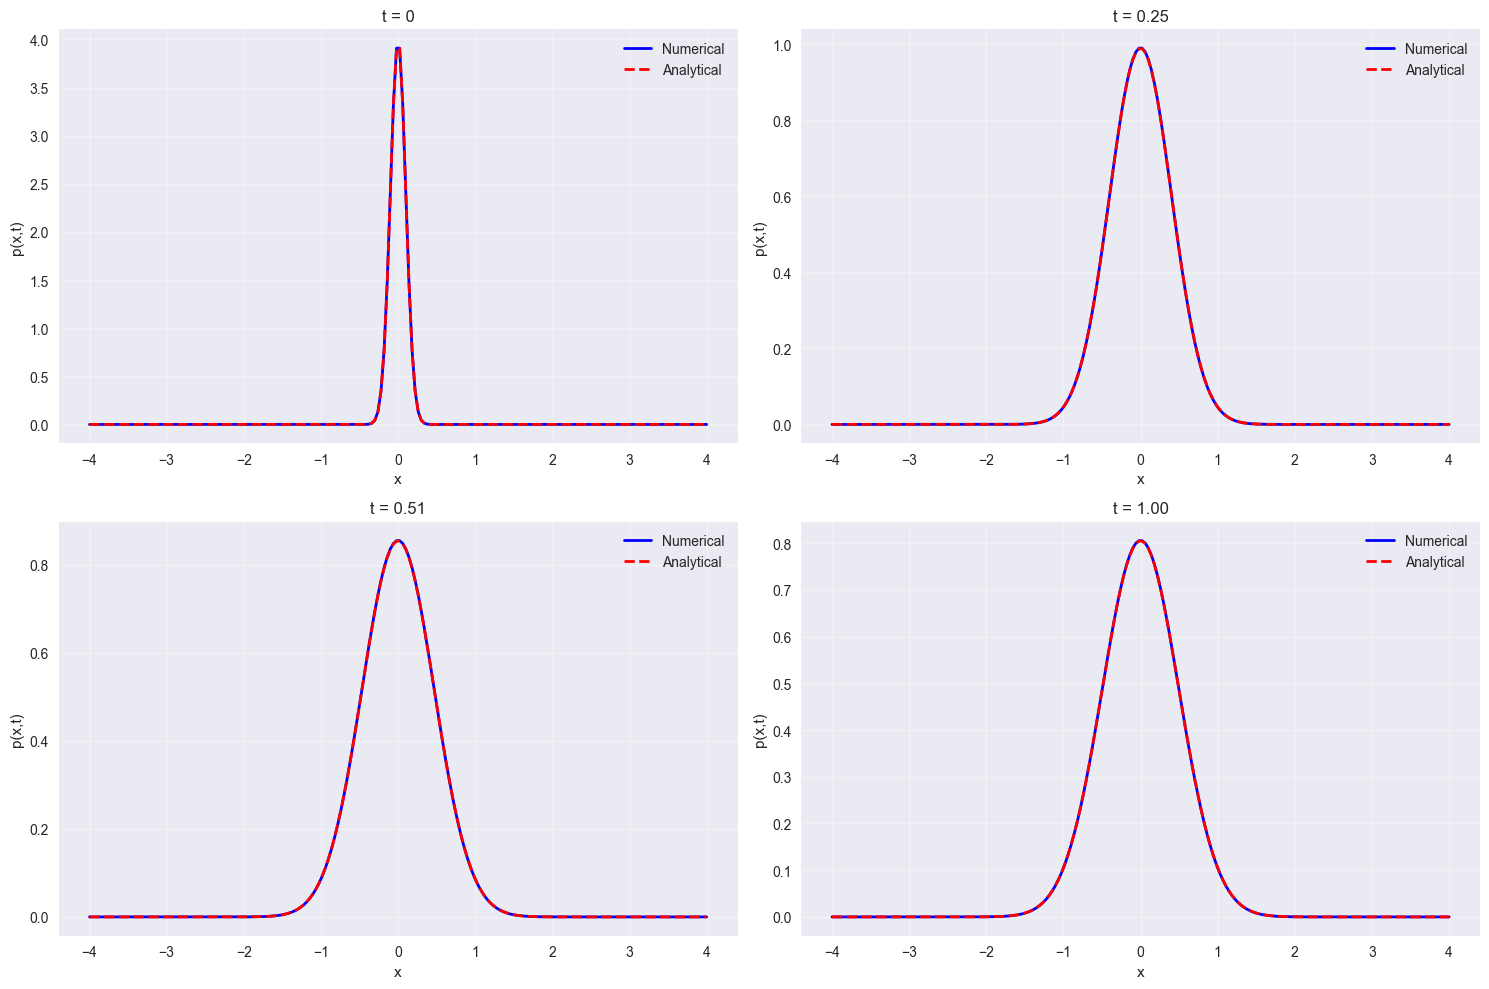

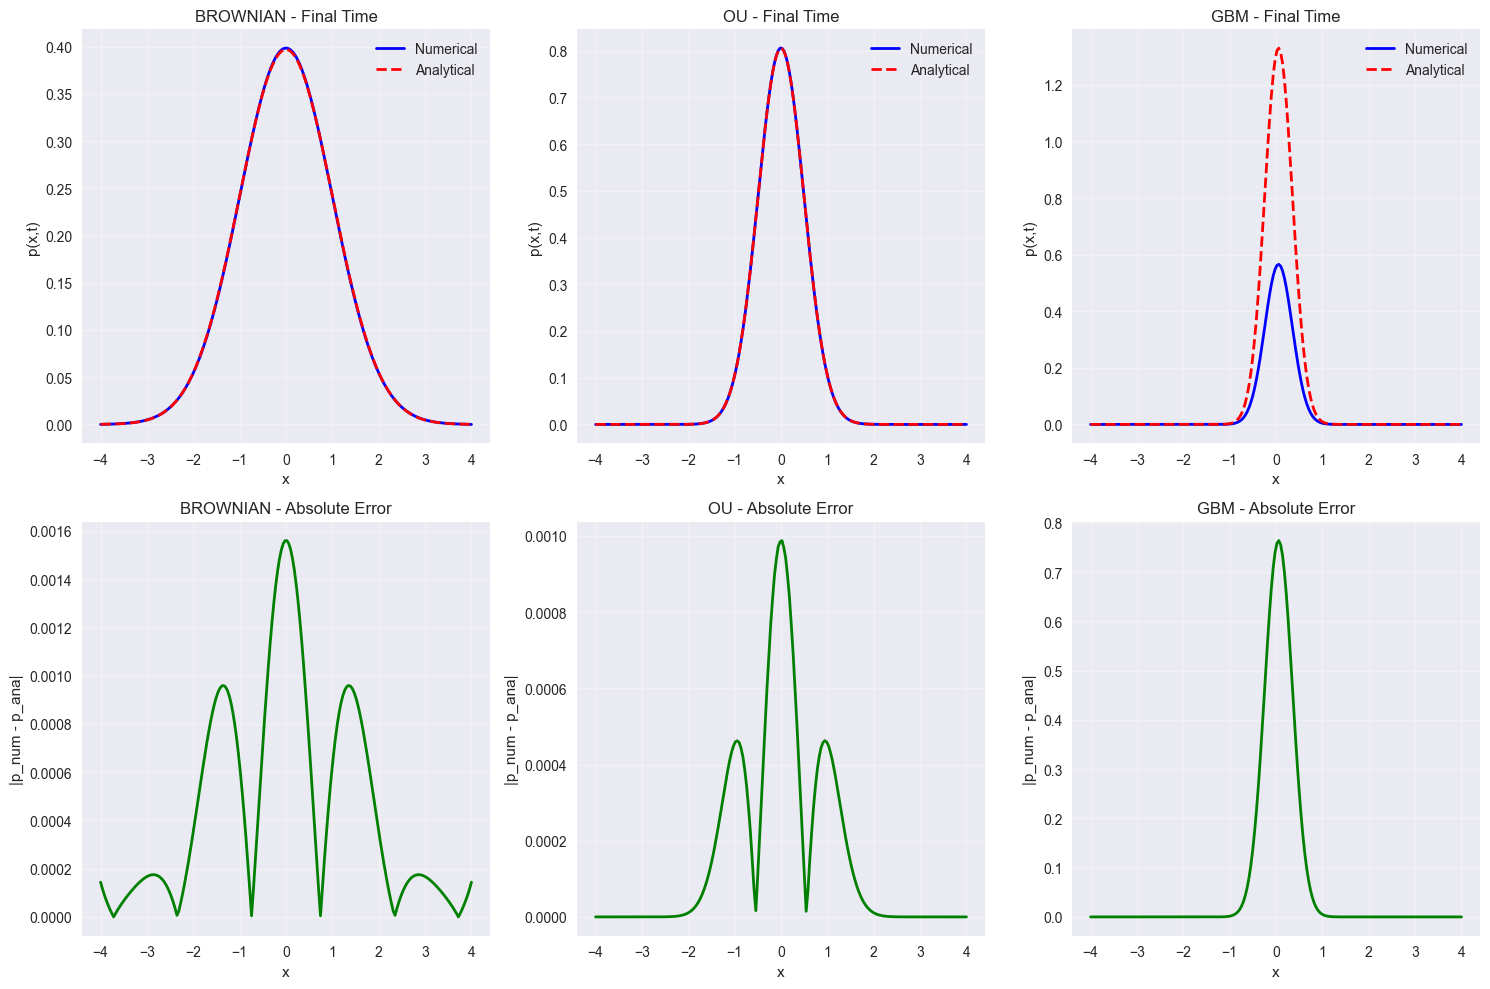


5. Monte Carlo Verification...
Running Monte Carlo verification for brownian...

FORWARD KOLMOGOROV EQUATION - EDUCATIONAL SUMMARY

The Forward Kolmogorov equation (also called Fokker-Planck equation)
describes how probability density functions evolve over time for
stochastic differential equations.

MATHEMATICAL FORMULATION:
For SDE: dX = μ(X,t)dt + σ(X,t)dW

Forward Kolmogorov equation:
∂p/∂t = -∂/∂x[μ(x,t)p] + (1/2)∂²/∂x²[σ²(x,t)p]

KEY COMPONENTS:
1. Drift term: -∂/∂x[μ(x,t)p] (convection)
2. Diffusion term: (1/2)∂²/∂x²[σ²(x,t)p] (spreading)

EXAMPLES IMPLEMENTED:
1. Brownian Motion: ∂p/∂t = (σ²/2)∂²p/∂x²
2. Ornstein-Uhlenbeck: ∂p/∂t = θ∂/∂x[xp] + (σ²/2)∂²p/∂x²
3. Geometric Brownian Motion (log-transformed)

NUMERICAL METHODS:
- Finite difference schemes
- Implicit time stepping for stability
- ODE system solving for complex cases

APPLICATIONS:
- Finance: Option pricing, risk management
- Physics: Particle diffusion, statistical mechanics
- Biology: Population dynamics, gene expr

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import seaborn as sns
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class ForwardKolmogorovSolver:
    """
    Comprehensive implementation of Forward Kolmogorov Equation solutions.
    
    The Forward Kolmogorov equation (Fokker-Planck equation) describes
    the evolution of probability density functions for stochastic processes.
    
    For SDE: dX = μ(X,t)dt + σ(X,t)dW
    The Forward Kolmogorov equation is:
    
    ∂p/∂t = -∂/∂x[μ(x,t)p] + (1/2)∂²/∂x²[σ²(x,t)p]
    
    where p(x,t) is the probability density function.
    """
    
    def __init__(self, x_min=-5, x_max=5, nx=200, t_max=2.0, nt=100):
        """
        Initialize the solver with grid parameters
        """
        self.x_min, self.x_max = x_min, x_max
        self.nx = nx
        self.t_max = t_max
        self.nt = nt
        
        # Create spatial grid
        self.x = np.linspace(x_min, x_max, nx)
        self.dx = self.x[1] - self.x[0]
        
        # Create time grid
        self.t = np.linspace(0, t_max, nt)
        self.dt = self.t[1] - self.t[0]
        
        # Storage for solutions
        self.solutions = {}
    
    def gaussian_initial_condition(self, x0=0, sigma0=0.5):
        """
        Gaussian initial probability density
        """
        return np.exp(-(self.x - x0)**2 / (2 * sigma0**2)) / (sigma0 * np.sqrt(2 * np.pi))
    
    def delta_initial_condition(self, x0=0, width=0.1):
        """
        Approximate delta function initial condition
        """
        return np.exp(-(self.x - x0)**2 / (2 * width**2)) / (width * np.sqrt(2 * np.pi))
    
    def solve_brownian_motion(self, sigma=1.0, x0=0, sigma0=0.1):
        """
        Solve Forward Kolmogorov equation for Brownian motion
        
        SDE: dX = σ dW
        Forward Kolmogorov: ∂p/∂t = (σ²/2) ∂²p/∂x²
        
        This is the standard diffusion equation.
        """
        print("Solving Forward Kolmogorov for Brownian Motion...")
        
        # Initial condition
        p0 = self.delta_initial_condition(x0, sigma0)
        
        # Coefficient matrix for implicit scheme
        alpha = sigma**2 * self.dt / (2 * self.dx**2)
        
        # Tridiagonal matrix for implicit scheme
        diag_main = 1 + 2 * alpha
        diag_off = -alpha
        
        A = diags([diag_off, diag_main, diag_off], [-1, 0, 1], 
                  shape=(self.nx, self.nx), format='csr')
        
        # Boundary conditions (absorbing)
        A[0, :] = 0
        A[0, 0] = 1
        A[-1, :] = 0
        A[-1, -1] = 1
        
        # Time evolution
        solution = np.zeros((self.nt, self.nx))
        solution[0] = p0
        
        for i in range(1, self.nt):
            # Right-hand side
            rhs = solution[i-1].copy()
            rhs[0] = 0  # Boundary condition
            rhs[-1] = 0  # Boundary condition
            
            # Solve linear system
            solution[i] = spsolve(A, rhs)
        
        # Analytical solution for comparison
        analytical = self.analytical_brownian_motion(sigma, x0, sigma0)
        
        self.solutions['brownian'] = {
            'numerical': solution,
            'analytical': analytical,
            'params': {'sigma': sigma, 'x0': x0, 'sigma0': sigma0}
        }
        
        return solution, analytical
    
    def analytical_brownian_motion(self, sigma, x0, sigma0):
        """
        Analytical solution for Brownian motion
        """
        solution = np.zeros((self.nt, self.nx))
        
        for i, t in enumerate(self.t):
            if t == 0:
                solution[i] = self.delta_initial_condition(x0, sigma0)
            else:
                variance = sigma0**2 + sigma**2 * t
                solution[i] = np.exp(-(self.x - x0)**2 / (2 * variance)) / np.sqrt(2 * np.pi * variance)
        
        return solution
    
    def solve_ornstein_uhlenbeck(self, theta=1.0, sigma=1.0, x0=0, sigma0=0.1):
        """
        Solve Forward Kolmogorov equation for Ornstein-Uhlenbeck process
        
        SDE: dX = -θX dt + σ dW
        Forward Kolmogorov: ∂p/∂t = θ∂/∂x[xp] + (σ²/2)∂²p/∂x²
        """
        print("Solving Forward Kolmogorov for Ornstein-Uhlenbeck...")
        
        # Initial condition
        p0 = self.delta_initial_condition(x0, sigma0)
        
        def ou_pde_system(t, p_flat):
            p = p_flat.reshape(self.nx)
            dpdt = np.zeros_like(p)
            
            # Interior points
            for i in range(1, self.nx-1):
                x_i = self.x[i]
                
                # First derivative (drift term)
                dp_dx = (p[i+1] - p[i-1]) / (2 * self.dx)
                
                # Second derivative (diffusion term)
                d2p_dx2 = (p[i+1] - 2*p[i] + p[i-1]) / self.dx**2
                
                # Forward Kolmogorov equation
                dpdt[i] = theta * (x_i * dp_dx + p[i]) + (sigma**2 / 2) * d2p_dx2
            
            # Boundary conditions (absorbing)
            dpdt[0] = 0
            dpdt[-1] = 0
            
            return dpdt.flatten()
        
        # Solve ODE system
        sol = solve_ivp(ou_pde_system, [0, self.t_max], p0.flatten(), 
                       t_eval=self.t, method='RK45', rtol=1e-8)
        
        solution = sol.y.T.reshape(self.nt, self.nx)
        
        # Analytical solution
        analytical = self.analytical_ornstein_uhlenbeck(theta, sigma, x0, sigma0)
        
        self.solutions['ou'] = {
            'numerical': solution,
            'analytical': analytical,
            'params': {'theta': theta, 'sigma': sigma, 'x0': x0, 'sigma0': sigma0}
        }
        
        return solution, analytical
    
    def analytical_ornstein_uhlenbeck(self, theta, sigma, x0, sigma0):
        """
        Analytical solution for Ornstein-Uhlenbeck process
        """
        solution = np.zeros((self.nt, self.nx))
        
        for i, t in enumerate(self.t):
            if t == 0:
                solution[i] = self.delta_initial_condition(x0, sigma0)
            else:
                # Mean and variance for OU process
                mean = x0 * np.exp(-theta * t)
                variance = sigma0**2 * np.exp(-2*theta*t) + (sigma**2/(2*theta)) * (1 - np.exp(-2*theta*t))
                
                solution[i] = np.exp(-(self.x - mean)**2 / (2 * variance)) / np.sqrt(2 * np.pi * variance)
        
        return solution
    
    def solve_geometric_brownian_motion(self, mu=0.1, sigma=0.2, S0=1.0, log_transform=True):
        """
        Solve Forward Kolmogorov equation for Geometric Brownian Motion
        
        SDE: dS = μS dt + σS dW
        
        Using log-transform: X = log(S)
        dX = (μ - σ²/2) dt + σ dW
        """
        print("Solving Forward Kolmogorov for Geometric Brownian Motion...")
        
        if log_transform:
            # Work in log-space
            x0 = np.log(S0)
            drift = mu - sigma**2/2
            
            # This becomes standard Brownian motion with drift
            p0 = self.delta_initial_condition(x0, 0.01)
            
            def gbm_pde_system(t, p_flat):
                p = p_flat.reshape(self.nx)
                dpdt = np.zeros_like(p)
                
                # Interior points
                for i in range(1, self.nx-1):
                    # First derivative
                    dp_dx = (p[i+1] - p[i-1]) / (2 * self.dx)
                    
                    # Second derivative
                    d2p_dx2 = (p[i+1] - 2*p[i] + p[i-1]) / self.dx**2
                    
                    # Forward Kolmogorov equation
                    dpdt[i] = -drift * dp_dx + (sigma**2 / 2) * d2p_dx2
                
                # Boundary conditions
                dpdt[0] = 0
                dpdt[-1] = 0
                
                return dpdt.flatten()
            
            # Solve ODE system
            sol = solve_ivp(gbm_pde_system, [0, self.t_max], p0.flatten(), 
                           t_eval=self.t, method='RK45', rtol=1e-8)
            
            solution = sol.y.T.reshape(self.nt, self.nx)
            
            # Analytical solution in log-space
            analytical = np.zeros((self.nt, self.nx))
            for i, t in enumerate(self.t):
                if t == 0:
                    analytical[i] = self.delta_initial_condition(x0, 0.01)
                else:
                    mean = x0 + drift * t
                    variance = sigma**2 * t
                    analytical[i] = np.exp(-(self.x - mean)**2 / (2 * variance)) / np.sqrt(2 * np.pi * variance)
        
        self.solutions['gbm'] = {
            'numerical': solution,
            'analytical': analytical,
            'params': {'mu': mu, 'sigma': sigma, 'S0': S0, 'log_space': log_transform}
        }
        
        return solution, analytical
    
    def solve_custom_sde(self, drift_func, diffusion_func, x0=0, sigma0=0.1):
        """
        Solve Forward Kolmogorov equation for custom SDE
        
        SDE: dX = μ(X,t) dt + σ(X,t) dW
        """
        print("Solving Forward Kolmogorov for Custom SDE...")
        
        p0 = self.delta_initial_condition(x0, sigma0)
        
        def custom_pde_system(t, p_flat):
            p = p_flat.reshape(self.nx)
            dpdt = np.zeros_like(p)
            
            # Interior points
            for i in range(1, self.nx-1):
                x_i = self.x[i]
                
                # Drift and diffusion coefficients
                mu = drift_func(x_i, t)
                sigma = diffusion_func(x_i, t)
                
                # First derivative
                dp_dx = (p[i+1] - p[i-1]) / (2 * self.dx)
                
                # Second derivative
                d2p_dx2 = (p[i+1] - 2*p[i] + p[i-1]) / self.dx**2
                
                # Forward Kolmogorov equation
                dpdt[i] = -(mu * dp_dx + p[i] * (mu * (1/self.dx) if i < self.nx-1 else 0)) + (sigma**2 / 2) * d2p_dx2
            
            # Boundary conditions
            dpdt[0] = 0
            dpdt[-1] = 0
            
            return dpdt.flatten()
        
        # Solve ODE system
        sol = solve_ivp(custom_pde_system, [0, self.t_max], p0.flatten(), 
                       t_eval=self.t, method='RK45', rtol=1e-8)
        
        solution = sol.y.T.reshape(self.nt, self.nx)
        
        return solution
    
    def monte_carlo_verification(self, sde_type='brownian', n_paths=10000, **params):
        """
        Verify Forward Kolmogorov solution using Monte Carlo simulation
        """
        print(f"Running Monte Carlo verification for {sde_type}...")
        
        dt_mc = self.dt / 10  # Finer time step for MC
        n_steps = int(self.t_max / dt_mc)
        
        # Initialize paths
        paths = np.zeros((n_paths, n_steps + 1))
        
        if sde_type == 'brownian':
            sigma = params.get('sigma', 1.0)
            x0 = params.get('x0', 0.0)
            
            paths[:, 0] = x0
            dW = np.random.normal(0, np.sqrt(dt_mc), (n_paths, n_steps))
            
            for i in range(n_steps):
                paths[:, i+1] = paths[:, i] + sigma * dW[:, i]
        
        elif sde_type == 'ou':
            theta = params.get('theta', 1.0)
            sigma = params.get('sigma', 1.0)
            x0 = params.get('x0', 0.0)
            
            paths[:, 0] = x0
            dW = np.random.normal(0, np.sqrt(dt_mc), (n_paths, n_steps))
            
            for i in range(n_steps):
                paths[:, i+1] = paths[:, i] - theta * paths[:, i] * dt_mc + sigma * dW[:, i]
        
        # Create histograms at different time points
        time_indices = [0, len(self.t)//4, len(self.t)//2, -1]
        mc_distributions = []
        
        for idx in time_indices:
            if idx == -1:
                mc_time_idx = -1
            else:
                mc_time_idx = int(idx * (n_steps / len(self.t)))
            
            hist, _ = np.histogram(paths[:, mc_time_idx], bins=self.x, density=True)
            mc_distributions.append(hist)
        
        return mc_distributions, time_indices
    
    def plot_evolution(self, solution_key='brownian', save_animation=False):
        """
        Plot the evolution of probability density
        """
        if solution_key not in self.solutions:
            print(f"Solution '{solution_key}' not found. Available: {list(self.solutions.keys())}")
            return
        
        solution = self.solutions[solution_key]['numerical']
        analytical = self.solutions[solution_key]['analytical']
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot at different time points
        time_indices = [0, len(self.t)//4, len(self.t)//2, -1]
        titles = ['t = 0', f't = {self.t[len(self.t)//4]:.2f}', 
                 f't = {self.t[len(self.t)//2]:.2f}', f't = {self.t[-1]:.2f}']
        
        for i, (ax, idx, title) in enumerate(zip(axes.flatten(), time_indices, titles)):
            if idx == -1:
                idx = len(self.t) - 1
            
            ax.plot(self.x, solution[idx], 'b-', linewidth=2, label='Numerical')
            ax.plot(self.x, analytical[idx], 'r--', linewidth=2, label='Analytical')
            ax.set_xlabel('x')
            ax.set_ylabel('p(x,t)')
            ax.set_title(title)
            ax.legend()
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create animation if requested
        if save_animation:
            self.create_animation(solution_key)
    
    def create_animation(self, solution_key='brownian'):
        """
        Create animation of probability density evolution
        """
        solution = self.solutions[solution_key]['numerical']
        analytical = self.solutions[solution_key]['analytical']
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Set up the plot
        ax.set_xlim(self.x_min, self.x_max)
        ax.set_ylim(0, np.max(solution) * 1.1)
        ax.set_xlabel('x')
        ax.set_ylabel('p(x,t)')
        ax.grid(True, alpha=0.3)
        
        # Initialize lines
        line_num, = ax.plot([], [], 'b-', linewidth=2, label='Numerical')
        line_ana, = ax.plot([], [], 'r--', linewidth=2, label='Analytical')
        time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
        ax.legend()
        
        def animate(frame):
            line_num.set_data(self.x, solution[frame])
            line_ana.set_data(self.x, analytical[frame])
            time_text.set_text(f't = {self.t[frame]:.3f}')
            return line_num, line_ana, time_text
        
        # Create animation
        anim = FuncAnimation(fig, animate, frames=len(self.t), 
                           interval=50, blit=True, repeat=True)
        
        plt.show()
        return anim
    
    def compare_all_solutions(self):
        """
        Compare all computed solutions
        """
        if not self.solutions:
            print("No solutions computed yet!")
            return
        
        n_solutions = len(self.solutions)
        fig, axes = plt.subplots(2, n_solutions, figsize=(5*n_solutions, 10))
        
        if n_solutions == 1:
            axes = axes.reshape(2, 1)
        
        for i, (key, data) in enumerate(self.solutions.items()):
            solution = data['numerical']
            analytical = data['analytical']
            params = data['params']
            
            # Plot at final time
            final_idx = -1
            
            # Numerical vs Analytical
            axes[0, i].plot(self.x, solution[final_idx], 'b-', linewidth=2, label='Numerical')
            axes[0, i].plot(self.x, analytical[final_idx], 'r--', linewidth=2, label='Analytical')
            axes[0, i].set_title(f'{key.upper()} - Final Time')
            axes[0, i].set_xlabel('x')
            axes[0, i].set_ylabel('p(x,t)')
            axes[0, i].legend()
            axes[0, i].grid(True, alpha=0.3)
            
            # Error analysis
            error = np.abs(solution[final_idx] - analytical[final_idx])
            axes[1, i].plot(self.x, error, 'g-', linewidth=2)
            axes[1, i].set_title(f'{key.upper()} - Absolute Error')
            axes[1, i].set_xlabel('x')
            axes[1, i].set_ylabel('|p_num - p_ana|')
            axes[1, i].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def educational_summary(self):
        """
        Print educational summary of Forward Kolmogorov equation
        """
        print("\n" + "="*70)
        print("FORWARD KOLMOGOROV EQUATION - EDUCATIONAL SUMMARY")
        print("="*70)
        
        print("""
The Forward Kolmogorov equation (also called Fokker-Planck equation)
describes how probability density functions evolve over time for
stochastic differential equations.

MATHEMATICAL FORMULATION:
For SDE: dX = μ(X,t)dt + σ(X,t)dW

Forward Kolmogorov equation:
∂p/∂t = -∂/∂x[μ(x,t)p] + (1/2)∂²/∂x²[σ²(x,t)p]

KEY COMPONENTS:
1. Drift term: -∂/∂x[μ(x,t)p] (convection)
2. Diffusion term: (1/2)∂²/∂x²[σ²(x,t)p] (spreading)

EXAMPLES IMPLEMENTED:
1. Brownian Motion: ∂p/∂t = (σ²/2)∂²p/∂x²
2. Ornstein-Uhlenbeck: ∂p/∂t = θ∂/∂x[xp] + (σ²/2)∂²p/∂x²
3. Geometric Brownian Motion (log-transformed)

NUMERICAL METHODS:
- Finite difference schemes
- Implicit time stepping for stability
- ODE system solving for complex cases

APPLICATIONS:
- Finance: Option pricing, risk management
- Physics: Particle diffusion, statistical mechanics
- Biology: Population dynamics, gene expression
- Engineering: Control systems, signal processing

RELATIONSHIP TO BACKWARD KOLMOGOROV:
- Forward: Evolution of probability density
- Backward: Evolution of expected values
- Connected through adjoint operators
        """)

def main():
    """
    Main demonstration of Forward Kolmogorov equation
    """
    print("Forward Kolmogorov Equation Demonstration")
    print("="*50)
    
    # Initialize solver
    solver = ForwardKolmogorovSolver(x_min=-4, x_max=4, nx=200, t_max=1.0, nt=100)
    
    # Solve different processes
    print("\n1. Brownian Motion")
    solver.solve_brownian_motion(sigma=1.0, x0=0.0)
    
    print("\n2. Ornstein-Uhlenbeck Process")
    solver.solve_ornstein_uhlenbeck(theta=2.0, sigma=1.0, x0=0.0)
    
    print("\n3. Geometric Brownian Motion")
    solver.solve_geometric_brownian_motion(mu=0.1, sigma=0.3, S0=1.0)
    
    # Plot results
    print("\n4. Visualizing Solutions...")
    solver.plot_evolution('brownian')
    solver.plot_evolution('ou')
    
    # Compare all solutions
    solver.compare_all_solutions()
    
    # Monte Carlo verification
    print("\n5. Monte Carlo Verification...")
    mc_dist, time_idx = solver.monte_carlo_verification('brownian', n_paths=50000, sigma=1.0, x0=0.0)
    
    # Educational summary
    solver.educational_summary()
    
    return solver

if __name__ == "__main__":
    solver = main()

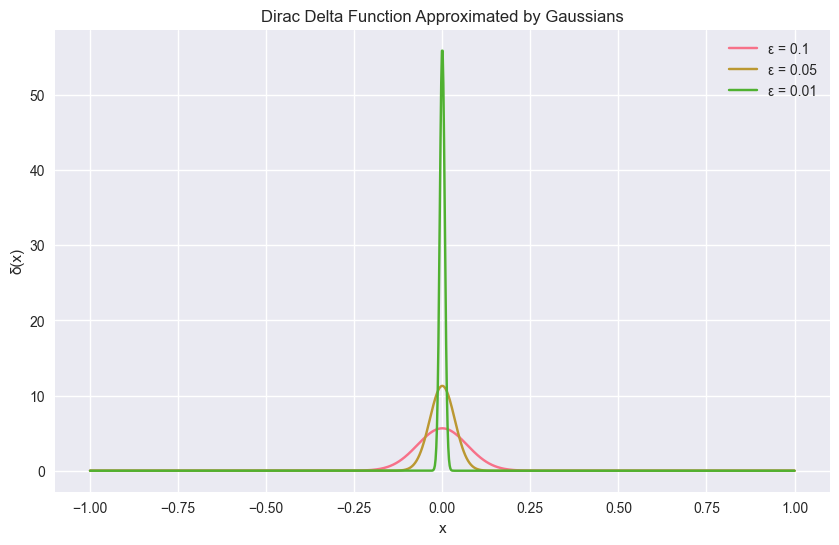

In [6]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-1, 1, 1000)
epsilons = [0.1, 0.05, 0.01]

plt.figure(figsize=(10, 6))
for eps in epsilons:
    delta_approx = 1/(eps * np.sqrt(np.pi)) * np.exp(-x**2 / eps**2)
    plt.plot(x, delta_approx, label=f"ε = {eps}")

plt.title("Dirac Delta Function Approximated by Gaussians")
plt.xlabel("x")
plt.ylabel("δ(x)")
plt.legend()
plt.grid(True)
plt.show()


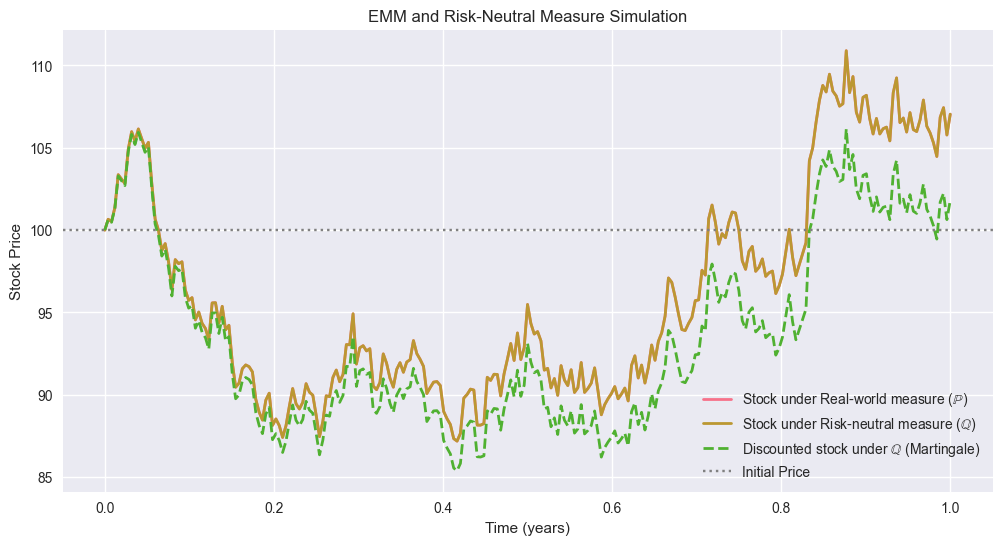

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100       # Initial stock price
mu = 0.1       # Real-world drift
r = 0.05       # Risk-free rate
sigma = 0.2    # Volatility
T = 1.0        # Time horizon (1 year)
N = 252        # Number of time steps (daily)
dt = T / N
theta = (mu - r) / sigma

# Time grid
t = np.linspace(0, T, N+1)

# Simulate Brownian motion under P
np.random.seed(42)
W_P = np.random.normal(0, np.sqrt(dt), size=N).cumsum()
W_P = np.insert(W_P, 0, 0)

# Simulate stock under P
S_P = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W_P)

# Apply Girsanov to get W_Q
W_Q = W_P + theta * t

# Simulate stock under Q
S_Q = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W_Q)

# Discounted stock price under Q (should be martingale)
discounted_S_Q = S_Q * np.exp(-r * t)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t, S_P, label="Stock under Real-world measure ($\mathbb{P}$)", lw=2)
plt.plot(t, S_Q, label="Stock under Risk-neutral measure ($\mathbb{Q}$)", lw=2)
plt.plot(t, discounted_S_Q, '--', label="Discounted stock under $\mathbb{Q}$ (Martingale)", lw=2)
plt.axhline(S0, color='gray', linestyle=':', label="Initial Price")
plt.title("EMM and Risk-Neutral Measure Simulation")
plt.xlabel("Time (years)")
plt.ylabel("Stock Price")
plt.grid(True)
plt.legend()
plt.show()


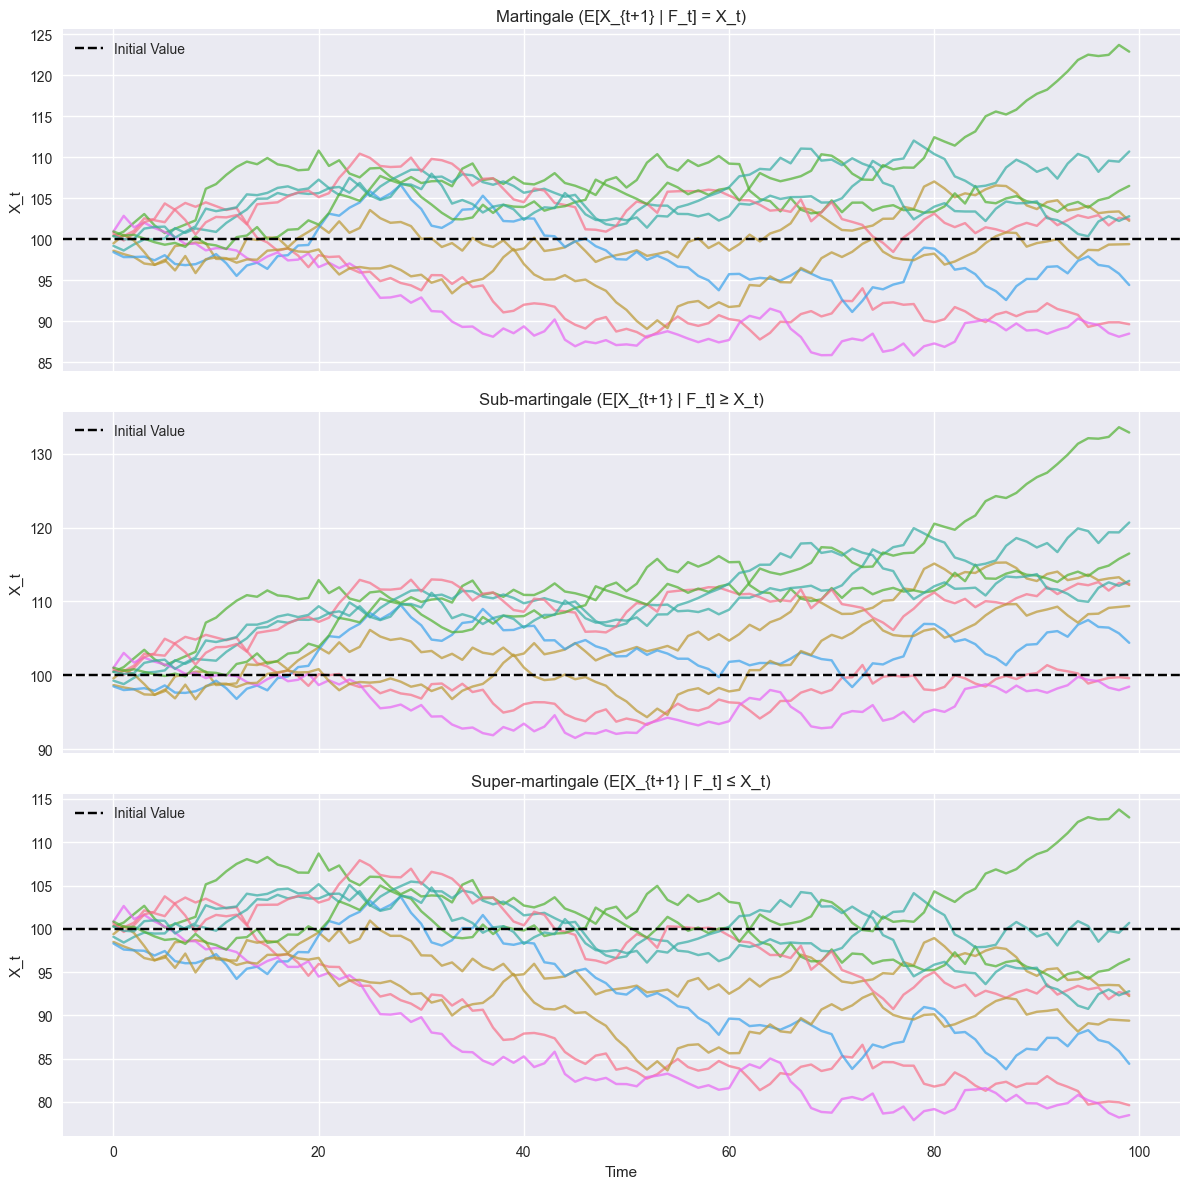

In [8]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Parameters
T = 100  # number of time steps
n_paths = 10  # number of sample paths
X0 = 100  # initial value

# Random noise
noise = np.random.normal(0, 1, size=(n_paths, T))

# Martingale: no drift
martingale = np.cumsum(noise, axis=1) + X0

# Sub-martingale: positive drift
sub_martingale = np.cumsum(noise + 0.1, axis=1) + X0

# Super-martingale: negative drift
super_martingale = np.cumsum(noise - 0.1, axis=1) + X0

# Add time axis
time = np.arange(T)

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Martingale
axs[0].set_title("Martingale (E[X_{t+1} | F_t] = X_t)")
for path in martingale:
    axs[0].plot(time, path, alpha=0.7)
axs[0].axhline(X0, color='black', linestyle='--', label="Initial Value")
axs[0].legend()

# Sub-martingale
axs[1].set_title("Sub-martingale (E[X_{t+1} | F_t] ≥ X_t)")
for path in sub_martingale:
    axs[1].plot(time, path, alpha=0.7)
axs[1].axhline(X0, color='black', linestyle='--', label="Initial Value")
axs[1].legend()

# Super-martingale
axs[2].set_title("Super-martingale (E[X_{t+1} | F_t] ≤ X_t)")
for path in super_martingale:
    axs[2].plot(time, path, alpha=0.7)
axs[2].axhline(X0, color='black', linestyle='--', label="Initial Value")
axs[2].legend()

for ax in axs:
    ax.set_ylabel("X_t")
    ax.grid(True)

axs[2].set_xlabel("Time")

plt.tight_layout()
plt.show()


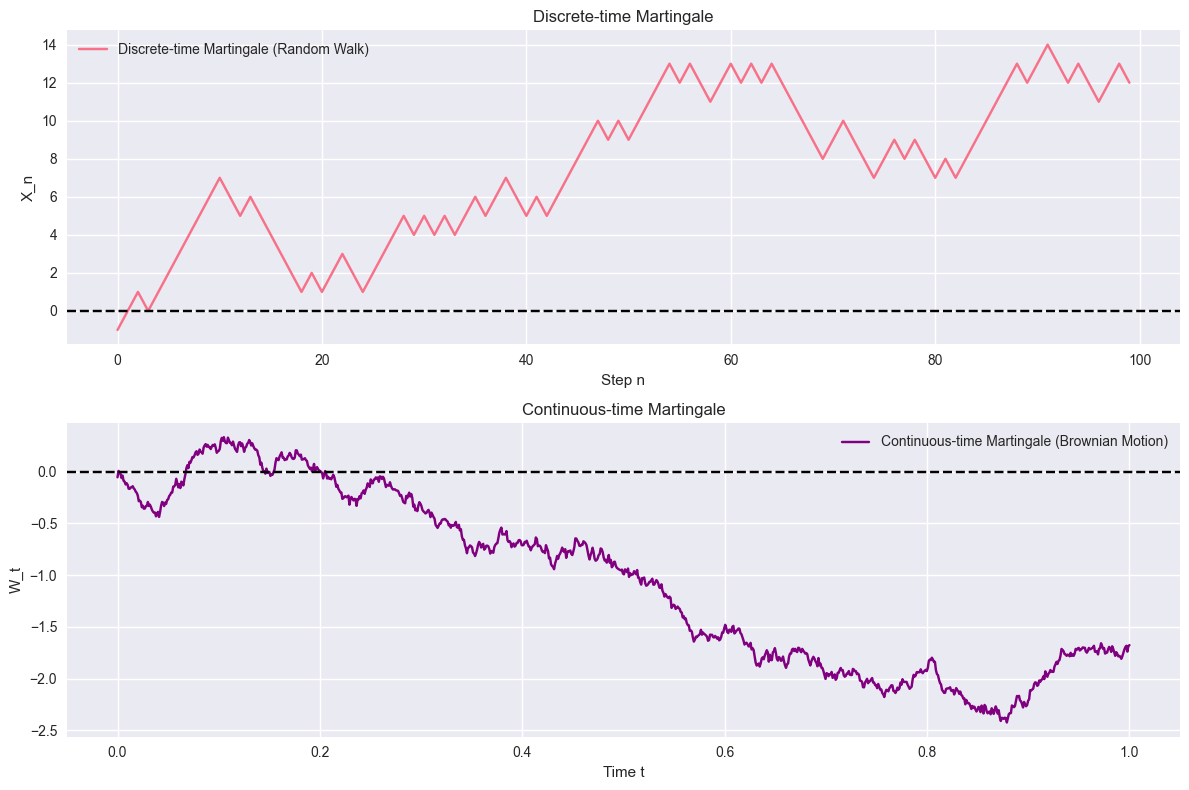

In [9]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# Parameters
T_discrete = 100
T_continuous = 1.0
N = 1000
dt = T_continuous / N
time_discrete = np.arange(T_discrete)
time_continuous = np.linspace(0, T_continuous, N)

# Discrete-time martingale: symmetric random walk
discrete_noise = np.random.choice([-1, 1], size=T_discrete)
X_discrete = np.cumsum(discrete_noise)

# Continuous-time martingale: Brownian motion (Wiener process)
continuous_noise = np.random.normal(0, np.sqrt(dt), size=N)
W = np.cumsum(continuous_noise)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Discrete-time martingale
axs[0].plot(time_discrete, X_discrete, label="Discrete-time Martingale (Random Walk)")
axs[0].axhline(0, color='black', linestyle='--')
axs[0].set_title("Discrete-time Martingale")
axs[0].set_xlabel("Step n")
axs[0].set_ylabel("X_n")
axs[0].grid(True)
axs[0].legend()

# Continuous-time martingale
axs[1].plot(time_continuous, W, label="Continuous-time Martingale (Brownian Motion)", color='purple')
axs[1].axhline(0, color='black', linestyle='--')
axs[1].set_title("Continuous-time Martingale")
axs[1].set_xlabel("Time t")
axs[1].set_ylabel("W_t")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


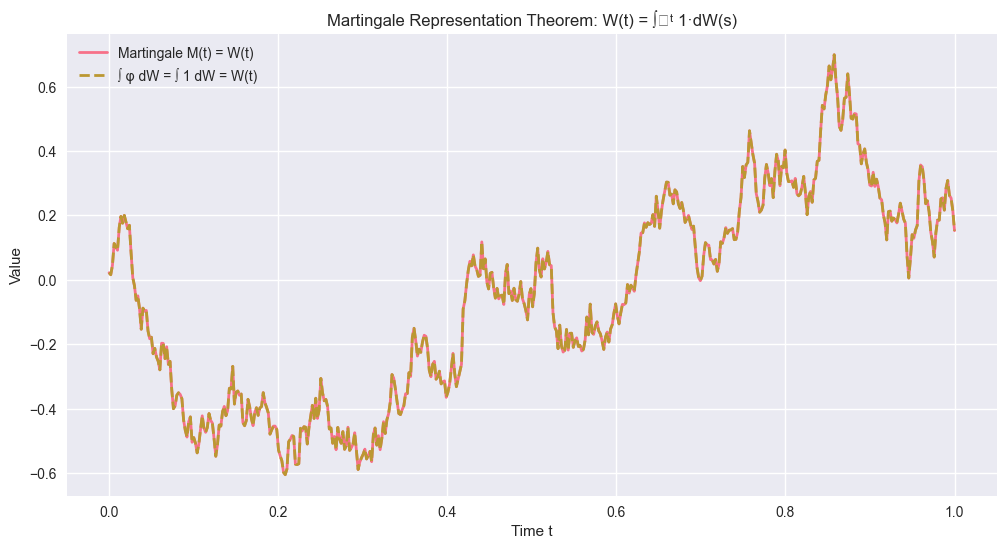

In [10]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Simulation parameters
T = 1.0
N = 500
dt = T / N
time = np.linspace(0, T, N)
sqrt_dt = np.sqrt(dt)

# Simulate a Brownian path
dW = np.random.normal(0, sqrt_dt, size=N)
W = np.cumsum(dW)

# Define X = W_T (final value), and M_t = E[W_T | F_t] = W_t + E[W_T - W_t | F_t]
# Since W_T - W_t is independent of F_t and ~ N(0, T - t), mean = 0
# So M_t = W_t (a martingale, trivially)

M_t = W.copy()  # M_t is just W_t in this example

# MRT: Represent M_t as integral of φ_s dW_s
# For this case, φ_s = 1, so:
phi = np.ones(N)
integral_representation = np.cumsum(phi * dW)

# Plot both martingale and its representation
plt.figure(figsize=(12, 6))
plt.plot(time, M_t, label='Martingale M(t) = W(t)', linewidth=2)
plt.plot(time, integral_representation, '--', label='∫ φ dW = ∫ 1 dW = W(t)', linewidth=2)
plt.title("Martingale Representation Theorem: W(t) = ∫₀ᵗ 1·dW(s)")
plt.xlabel("Time t")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()


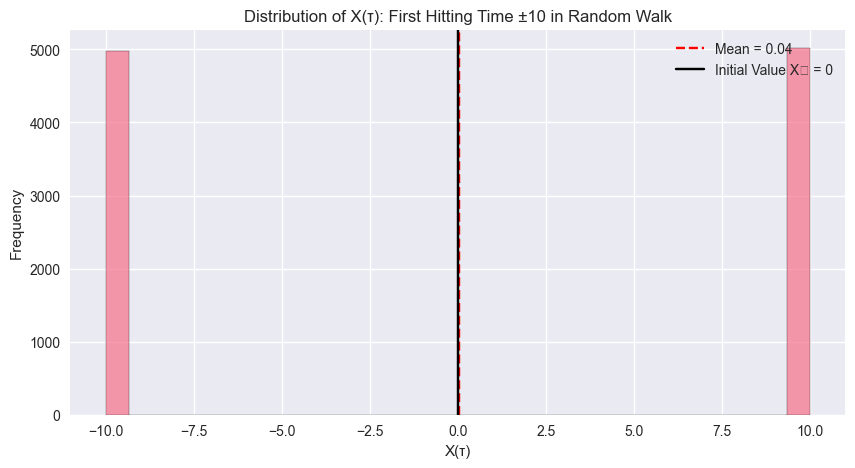

np.float64(0.036)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

# Parameters
n_paths = 10000  # number of random walks
max_steps = 1000
threshold = 10  # stopping barrier
X0 = 0

# Initialize array to store final values at stopping time
X_tau = []

for _ in range(n_paths):
    steps = np.random.choice([-1, 1], size=max_steps)
    walk = np.cumsum(np.insert(steps, 0, X0))  # insert initial value
    tau_hit = np.where((walk >= threshold) | (walk <= -threshold))[0]

    # stopping time: first hit of +/- threshold
    if len(tau_hit) > 0:
        tau = tau_hit[0]
        X_tau.append(walk[tau])
    else:
        # If threshold never hit (should be rare with enough steps)
        X_tau.append(walk[-1])

# Compute expectation
expected_X_tau = np.mean(X_tau)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(X_tau, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(expected_X_tau, color='red', linestyle='--', label=f"Mean = {expected_X_tau:.2f}")
plt.axvline(0, color='black', linestyle='-', label="Initial Value X₀ = 0")
plt.title("Distribution of X(τ): First Hitting Time ±10 in Random Walk")
plt.xlabel("X(τ)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

expected_X_tau


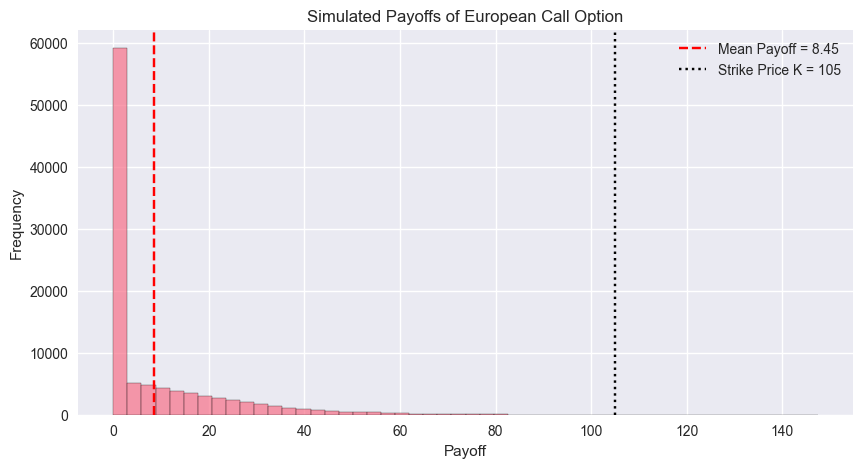

np.float64(8.041620675135178)

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
S0 = 100        # initial stock price
K = 105         # strike price
r = 0.05        # risk-free rate
sigma = 0.2     # volatility
T = 1.0         # time to maturity (in years)
n_paths = 100000  # number of simulated paths

np.random.seed(42)

# Simulate stock price at maturity under risk-neutral measure (GBM)
Z = np.random.normal(0, 1, n_paths)
ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

# Payoff of European call option
payoffs = np.maximum(ST - K, 0)

# Discounted expected payoff (risk-neutral pricing)
V0 = np.exp(-r * T) * np.mean(payoffs)

# Plotting
plt.figure(figsize=(10, 5))
plt.hist(payoffs, bins=50, alpha=0.7, edgecolor='k')
plt.axvline(np.mean(payoffs), color='red', linestyle='--', label=f"Mean Payoff = {np.mean(payoffs):.2f}")
plt.axvline(K, color='black', linestyle=':', label=f"Strike Price K = {K}")
plt.title("Simulated Payoffs of European Call Option")
plt.xlabel("Payoff")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

V0  # Return the option price


🚀 Advanced Option Pricing Analysis
Running comprehensive analysis...

📊 RESULTS SUMMARY
------------------------------
Black-Scholes Price: $8.0214
Monte Carlo Price: $7.9667
Binomial Tree Price: $8.0262

Monte Carlo Statistics:
  Standard Error: 0.0190
  95% Confidence Interval: [7.9296, 8.0039]

Option Greeks:
  Delta: 0.5422
  Gamma: 0.0198
  Theta: -0.0172
  Vega: 0.3967
  Rho: 0.4620

📈 Generating comprehensive visualizations...


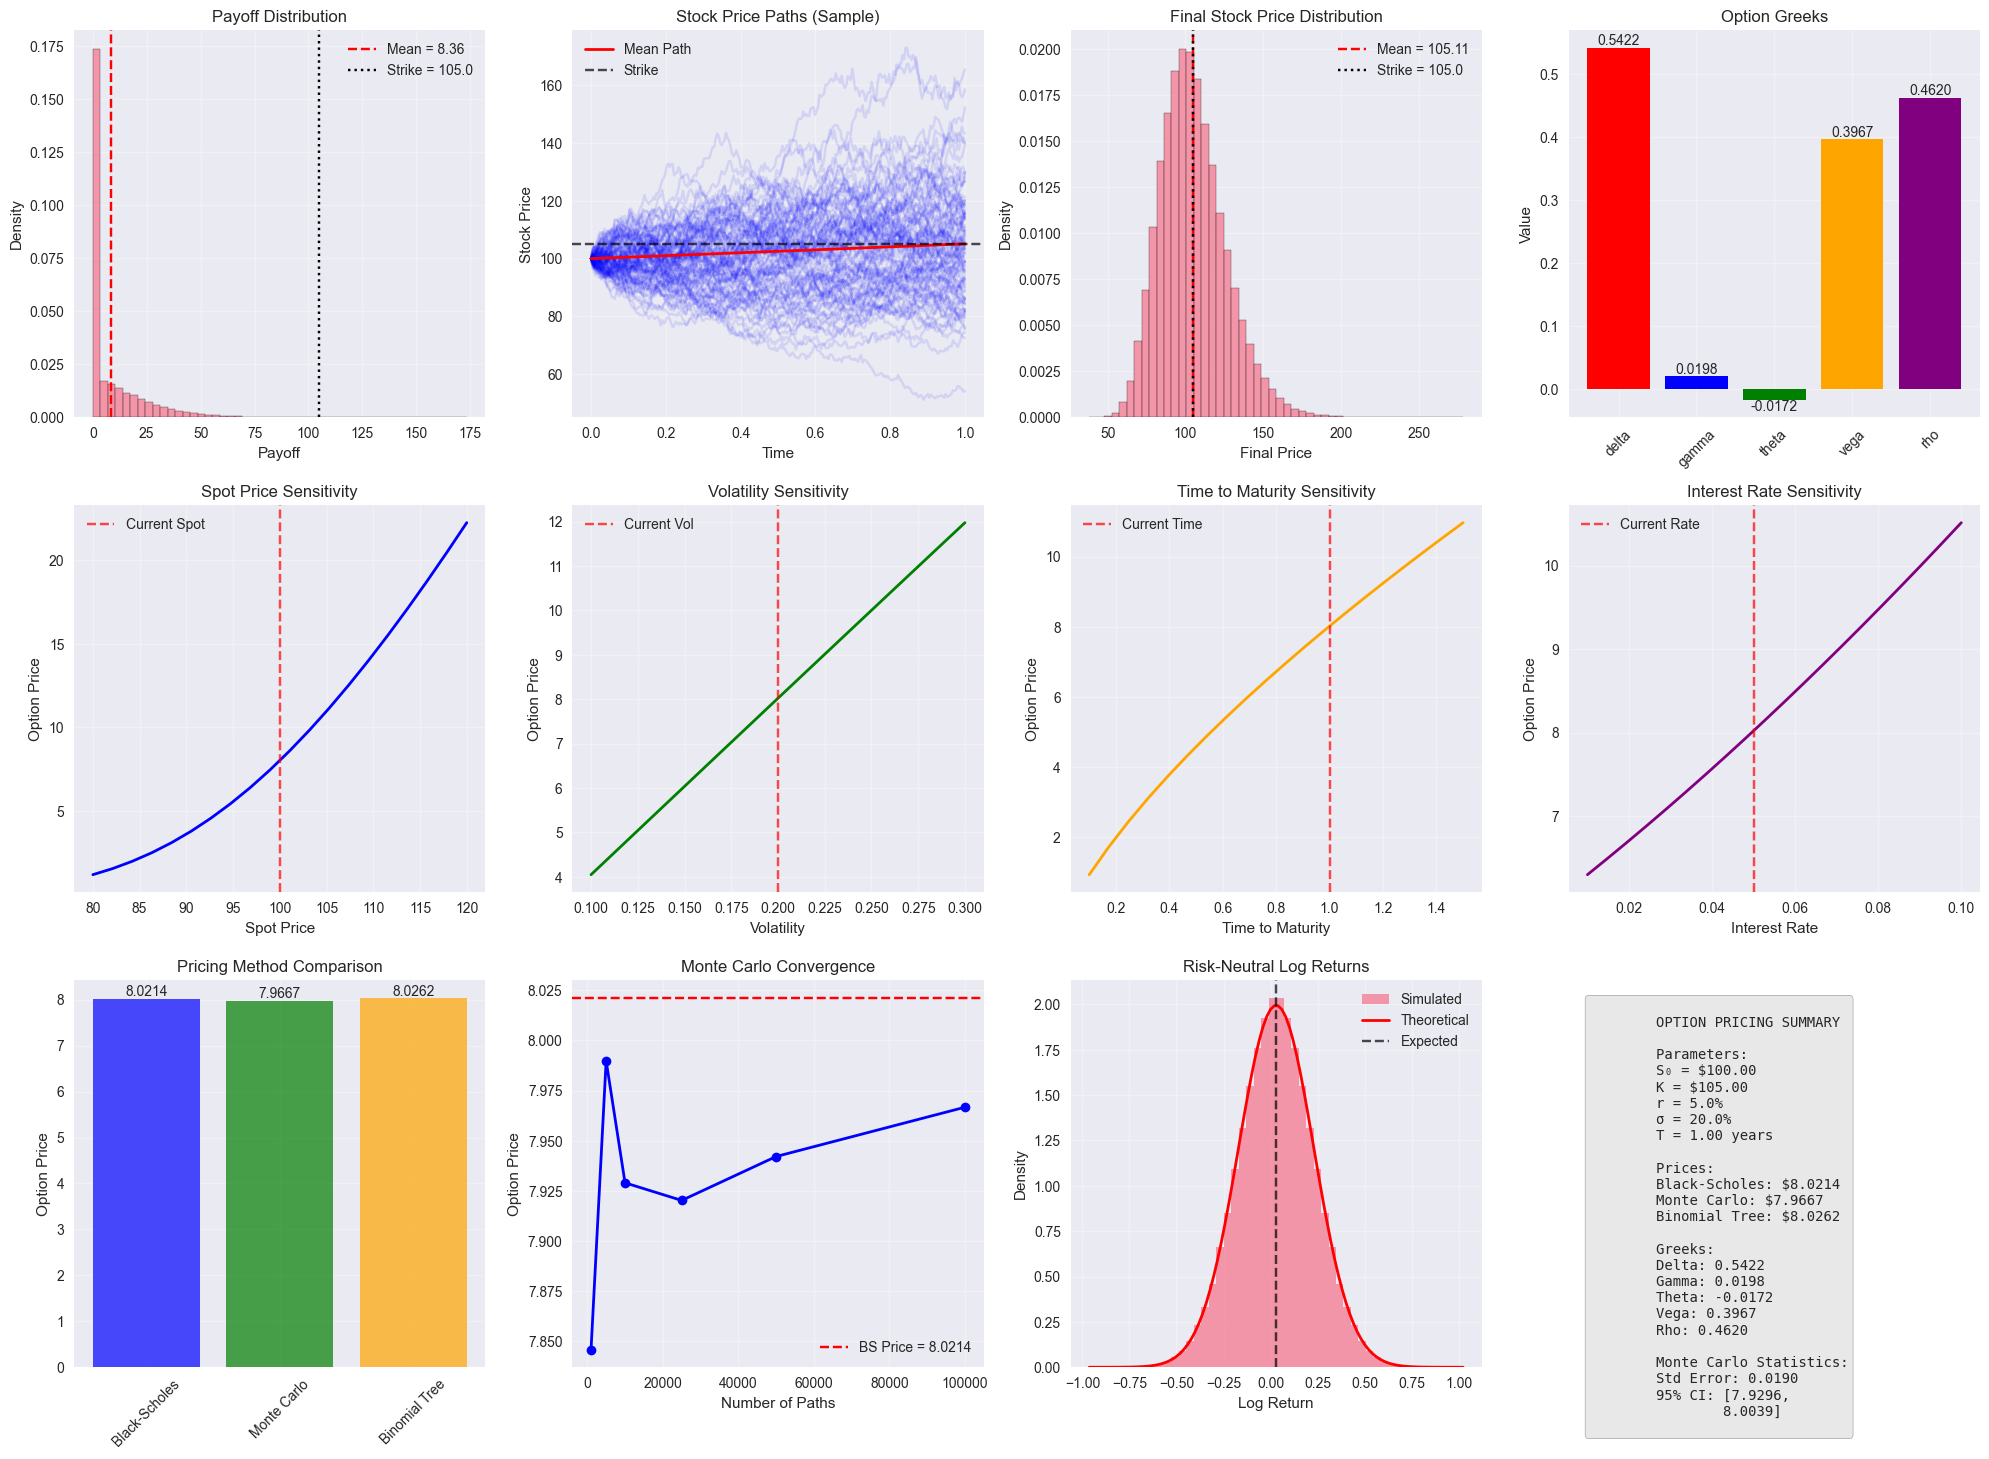


🚧 Barrier Option Example
------------------------------
Up-and-Out Barrier Call (Barrier = $110): $0.0225

😊 Volatility Smile Analysis
------------------------------


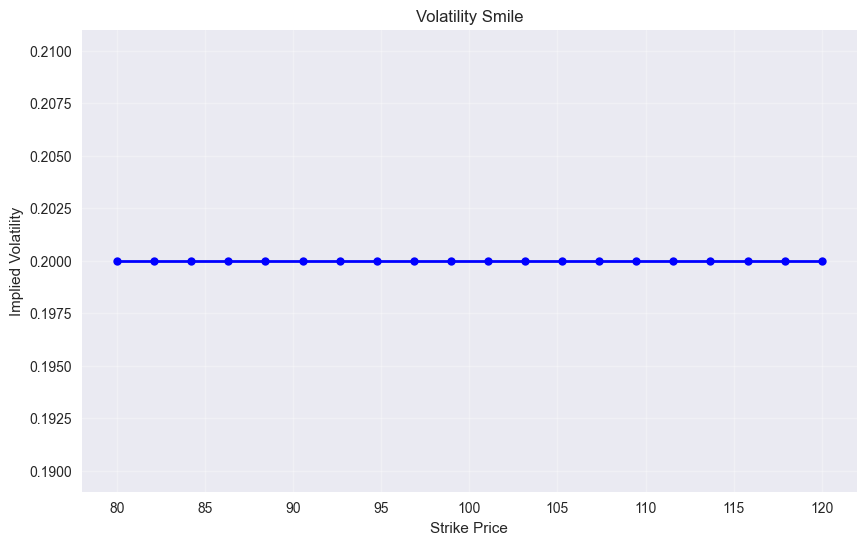


✅ Analysis Complete!
All visualizations have been generated.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

@dataclass
class OptionParameters:
    """Class to store option parameters"""
    S0: float = 100.0      # Initial stock price
    K: float = 105.0       # Strike price
    r: float = 0.05        # Risk-free rate
    sigma: float = 0.2     # Volatility
    T: float = 1.0         # Time to maturity
    option_type: str = 'call'  # 'call' or 'put'
    barrier: Optional[float] = None  # For barrier options
    barrier_type: Optional[str] = None  # 'up-out', 'down-out', 'up-in', 'down-in'

class AdvancedOptionPricer:
    """Advanced option pricing class with multiple methods and visualizations"""
    
    def __init__(self, params: OptionParameters):
        self.params = params
        self.results = {}
        
    def black_scholes_price(self) -> float:
        """Calculate Black-Scholes analytical price"""
        S, K, r, sigma, T = self.params.S0, self.params.K, self.params.r, self.params.sigma, self.params.T
        
        d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        
        if self.params.option_type == 'call':
            return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        else:  # put
            return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    
    def calculate_greeks(self) -> Dict[str, float]:
        """Calculate option Greeks"""
        S, K, r, sigma, T = self.params.S0, self.params.K, self.params.r, self.params.sigma, self.params.T
        
        d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        
        # Delta
        if self.params.option_type == 'call':
            delta = norm.cdf(d1)
        else:
            delta = norm.cdf(d1) - 1
        
        # Gamma
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        
        # Theta
        if self.params.option_type == 'call':
            theta = (-S*norm.pdf(d1)*sigma/(2*np.sqrt(T)) - r*K*np.exp(-r*T)*norm.cdf(d2)) / 365
        else:
            theta = (-S*norm.pdf(d1)*sigma/(2*np.sqrt(T)) + r*K*np.exp(-r*T)*norm.cdf(-d2)) / 365
        
        # Vega
        vega = S * norm.pdf(d1) * np.sqrt(T) / 100
        
        # Rho
        if self.params.option_type == 'call':
            rho = K * T * np.exp(-r*T) * norm.cdf(d2) / 100
        else:
            rho = -K * T * np.exp(-r*T) * norm.cdf(-d2) / 100
        
        return {
            'delta': delta,
            'gamma': gamma,
            'theta': theta,
            'vega': vega,
            'rho': rho
        }
    
    def monte_carlo_pricing(self, n_paths: int = 100000, n_steps: int = 252, 
                          antithetic: bool = True, control_variate: bool = True) -> Dict:
        """Advanced Monte Carlo pricing with variance reduction techniques"""
        np.random.seed(42)
        
        dt = self.params.T / n_steps
        S, K, r, sigma, T = self.params.S0, self.params.K, self.params.r, self.params.sigma, self.params.T
        
        # Generate random numbers
        if antithetic:
            Z = np.random.normal(0, 1, (n_paths//2, n_steps))
            Z = np.vstack([Z, -Z])  # Antithetic variates
        else:
            Z = np.random.normal(0, 1, (n_paths, n_steps))
        
        # Simulate stock price paths
        log_returns = (r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z
        log_price_paths = np.log(S) + np.cumsum(log_returns, axis=1)
        price_paths = np.exp(log_price_paths)
        
        # Add initial price
        price_paths = np.hstack([S*np.ones((n_paths, 1)), price_paths])
        
        # Calculate payoffs
        ST = price_paths[:, -1]
        
        if self.params.option_type == 'call':
            payoffs = np.maximum(ST - K, 0)
        else:
            payoffs = np.maximum(K - ST, 0)
        
        # Handle barrier options
        if self.params.barrier is not None:
            barrier_hit = self._check_barrier_conditions(price_paths)
            if self.params.barrier_type in ['up-out', 'down-out']:
                payoffs = payoffs * (1 - barrier_hit)
            else:  # up-in, down-in
                payoffs = payoffs * barrier_hit
        
        # Control variate technique
        if control_variate:
            # Use the stock price as control variate
            control_payoffs = ST - S*np.exp(r*T)  # Zero expectation under risk-neutral measure
            
            # Calculate covariance and variance
            cov = np.cov(payoffs, control_payoffs)[0, 1]
            var_control = np.var(control_payoffs)
            
            # Optimal coefficient
            if var_control > 0:
                c = cov / var_control
                payoffs_cv = payoffs - c * control_payoffs
            else:
                payoffs_cv = payoffs
        else:
            payoffs_cv = payoffs
        
        # Calculate price and statistics
        discounted_payoffs = np.exp(-r*T) * payoffs_cv
        price = np.mean(discounted_payoffs)
        std_error = np.std(discounted_payoffs) / np.sqrt(n_paths)
        
        # Confidence interval
        confidence_interval = (price - 1.96*std_error, price + 1.96*std_error)
        
        return {
            'price': price,
            'std_error': std_error,
            'confidence_interval': confidence_interval,
            'payoffs': payoffs,
            'price_paths': price_paths,
            'final_prices': ST
        }
    
    def _check_barrier_conditions(self, price_paths: np.ndarray) -> np.ndarray:
        """Check if barrier conditions are met"""
        barrier = self.params.barrier
        
        if self.params.barrier_type == 'up-out':
            return np.any(price_paths >= barrier, axis=1)
        elif self.params.barrier_type == 'down-out':
            return np.any(price_paths <= barrier, axis=1)
        elif self.params.barrier_type == 'up-in':
            return np.any(price_paths >= barrier, axis=1)
        elif self.params.barrier_type == 'down-in':
            return np.any(price_paths <= barrier, axis=1)
        else:
            return np.zeros(price_paths.shape[0], dtype=bool)
    
    def binomial_tree_pricing(self, n_steps: int = 100) -> Dict:
        """Binomial tree pricing method"""
        S, K, r, sigma, T = self.params.S0, self.params.K, self.params.r, self.params.sigma, self.params.T
        
        dt = T / n_steps
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp(r * dt) - d) / (u - d)
        
        # Initialize price tree
        price_tree = np.zeros((n_steps + 1, n_steps + 1))
        
        # Fill the price tree
        for i in range(n_steps + 1):
            for j in range(i + 1):
                price_tree[j, i] = S * (u ** j) * (d ** (i - j))
        
        # Initialize option value tree
        option_tree = np.zeros((n_steps + 1, n_steps + 1))
        
        # Fill terminal payoffs
        for j in range(n_steps + 1):
            if self.params.option_type == 'call':
                option_tree[j, n_steps] = max(price_tree[j, n_steps] - K, 0)
            else:
                option_tree[j, n_steps] = max(K - price_tree[j, n_steps], 0)
        
        # Backward induction
        for i in range(n_steps - 1, -1, -1):
            for j in range(i + 1):
                option_tree[j, i] = np.exp(-r * dt) * (
                    p * option_tree[j + 1, i + 1] + (1 - p) * option_tree[j, i + 1]
                )
        
        return {
            'price': option_tree[0, 0],
            'price_tree': price_tree,
            'option_tree': option_tree
        }
    
    def sensitivity_analysis(self) -> Dict:
        """Perform sensitivity analysis on key parameters"""
        base_params = self.params
        
        # Parameter ranges
        spot_range = np.linspace(base_params.S0 * 0.8, base_params.S0 * 1.2, 20)
        vol_range = np.linspace(base_params.sigma * 0.5, base_params.sigma * 1.5, 20)
        time_range = np.linspace(0.1, base_params.T * 1.5, 20)
        rate_range = np.linspace(0.01, 0.10, 20)
        
        # Calculate sensitivities
        spot_prices = []
        vol_prices = []
        time_prices = []
        rate_prices = []
        
        for spot in spot_range:
            params = OptionParameters(
                S0=spot, K=base_params.K, r=base_params.r, 
                sigma=base_params.sigma, T=base_params.T, 
                option_type=base_params.option_type
            )
            pricer = AdvancedOptionPricer(params)
            spot_prices.append(pricer.black_scholes_price())
        
        for vol in vol_range:
            params = OptionParameters(
                S0=base_params.S0, K=base_params.K, r=base_params.r, 
                sigma=vol, T=base_params.T, 
                option_type=base_params.option_type
            )
            pricer = AdvancedOptionPricer(params)
            vol_prices.append(pricer.black_scholes_price())
        
        for time in time_range:
            params = OptionParameters(
                S0=base_params.S0, K=base_params.K, r=base_params.r, 
                sigma=base_params.sigma, T=time, 
                option_type=base_params.option_type
            )
            pricer = AdvancedOptionPricer(params)
            time_prices.append(pricer.black_scholes_price())
        
        for rate in rate_range:
            params = OptionParameters(
                S0=base_params.S0, K=base_params.K, r=rate, 
                sigma=base_params.sigma, T=base_params.T, 
                option_type=base_params.option_type
            )
            pricer = AdvancedOptionPricer(params)
            rate_prices.append(pricer.black_scholes_price())
        
        return {
            'spot_range': spot_range,
            'spot_prices': spot_prices,
            'vol_range': vol_range,
            'vol_prices': vol_prices,
            'time_range': time_range,
            'time_prices': time_prices,
            'rate_range': rate_range,
            'rate_prices': rate_prices
        }
    
    def comprehensive_analysis(self, n_paths: int = 100000) -> Dict:
        """Run comprehensive analysis with all methods"""
        results = {}
        
        # Black-Scholes price
        results['black_scholes'] = self.black_scholes_price()
        
        # Greeks
        results['greeks'] = self.calculate_greeks()
        
        # Monte Carlo
        results['monte_carlo'] = self.monte_carlo_pricing(n_paths)
        
        # Binomial tree
        results['binomial'] = self.binomial_tree_pricing()
        
        # Sensitivity analysis
        results['sensitivity'] = self.sensitivity_analysis()
        
        return results
    
    def create_comprehensive_plots(self, results: Dict) -> None:
        """Create comprehensive visualization plots"""
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Payoff distribution
        plt.subplot(3, 4, 1)
        payoffs = results['monte_carlo']['payoffs']
        plt.hist(payoffs, bins=50, alpha=0.7, edgecolor='k', density=True)
        plt.axvline(np.mean(payoffs), color='red', linestyle='--', 
                   label=f"Mean = {np.mean(payoffs):.2f}")
        plt.axvline(self.params.K, color='black', linestyle=':', 
                   label=f"Strike = {self.params.K}")
        plt.title("Payoff Distribution")
        plt.xlabel("Payoff")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Price paths sample
        plt.subplot(3, 4, 2)
        price_paths = results['monte_carlo']['price_paths']
        time_steps = np.linspace(0, self.params.T, price_paths.shape[1])
        
        # Plot sample paths
        for i in range(min(100, price_paths.shape[0])):
            plt.plot(time_steps, price_paths[i], alpha=0.1, color='blue')
        
        # Plot mean path
        mean_path = np.mean(price_paths, axis=0)
        plt.plot(time_steps, mean_path, color='red', linewidth=2, label='Mean Path')
        plt.axhline(self.params.K, color='black', linestyle='--', alpha=0.7, label='Strike')
        plt.title("Stock Price Paths (Sample)")
        plt.xlabel("Time")
        plt.ylabel("Stock Price")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Final price distribution
        plt.subplot(3, 4, 3)
        final_prices = results['monte_carlo']['final_prices']
        plt.hist(final_prices, bins=50, alpha=0.7, edgecolor='k', density=True)
        plt.axvline(np.mean(final_prices), color='red', linestyle='--', 
                   label=f"Mean = {np.mean(final_prices):.2f}")
        plt.axvline(self.params.K, color='black', linestyle=':', 
                   label=f"Strike = {self.params.K}")
        plt.title("Final Stock Price Distribution")
        plt.xlabel("Final Price")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. Greeks visualization
        plt.subplot(3, 4, 4)
        greeks = results['greeks']
        greek_names = list(greeks.keys())
        greek_values = list(greeks.values())
        
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        bars = plt.bar(greek_names, greek_values, color=colors)
        plt.title("Option Greeks")
        plt.ylabel("Value")
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, greek_values):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{value:.4f}', ha='center', va='bottom' if height >= 0 else 'top')
        plt.grid(True, alpha=0.3)
        
        # 5-8. Sensitivity analysis
        sensitivity = results['sensitivity']
        
        # Spot price sensitivity
        plt.subplot(3, 4, 5)
        plt.plot(sensitivity['spot_range'], sensitivity['spot_prices'], 'b-', linewidth=2)
        plt.axvline(self.params.S0, color='red', linestyle='--', alpha=0.7, label='Current Spot')
        plt.title("Spot Price Sensitivity")
        plt.xlabel("Spot Price")
        plt.ylabel("Option Price")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Volatility sensitivity
        plt.subplot(3, 4, 6)
        plt.plot(sensitivity['vol_range'], sensitivity['vol_prices'], 'g-', linewidth=2)
        plt.axvline(self.params.sigma, color='red', linestyle='--', alpha=0.7, label='Current Vol')
        plt.title("Volatility Sensitivity")
        plt.xlabel("Volatility")
        plt.ylabel("Option Price")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Time to maturity sensitivity
        plt.subplot(3, 4, 7)
        plt.plot(sensitivity['time_range'], sensitivity['time_prices'], 'orange', linewidth=2)
        plt.axvline(self.params.T, color='red', linestyle='--', alpha=0.7, label='Current Time')
        plt.title("Time to Maturity Sensitivity")
        plt.xlabel("Time to Maturity")
        plt.ylabel("Option Price")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Interest rate sensitivity
        plt.subplot(3, 4, 8)
        plt.plot(sensitivity['rate_range'], sensitivity['rate_prices'], 'purple', linewidth=2)
        plt.axvline(self.params.r, color='red', linestyle='--', alpha=0.7, label='Current Rate')
        plt.title("Interest Rate Sensitivity")
        plt.xlabel("Interest Rate")
        plt.ylabel("Option Price")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 9. Method comparison
        plt.subplot(3, 4, 9)
        methods = ['Black-Scholes', 'Monte Carlo', 'Binomial Tree']
        prices = [results['black_scholes'], results['monte_carlo']['price'], results['binomial']['price']]
        
        bars = plt.bar(methods, prices, color=['blue', 'green', 'orange'], alpha=0.7)
        plt.title("Pricing Method Comparison")
        plt.ylabel("Option Price")
        plt.xticks(rotation=45)
        
        # Add value labels
        for bar, price in zip(bars, prices):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{price:.4f}', ha='center', va='bottom')
        plt.grid(True, alpha=0.3)
        
        # 10. Convergence analysis
        plt.subplot(3, 4, 10)
        path_counts = [1000, 5000, 10000, 25000, 50000, 100000]
        mc_prices = []
        
        for n in path_counts:
            mc_result = self.monte_carlo_pricing(n_paths=n)
            mc_prices.append(mc_result['price'])
        
        plt.plot(path_counts, mc_prices, 'bo-', linewidth=2)
        plt.axhline(results['black_scholes'], color='red', linestyle='--', 
                   label=f"BS Price = {results['black_scholes']:.4f}")
        plt.title("Monte Carlo Convergence")
        plt.xlabel("Number of Paths")
        plt.ylabel("Option Price")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 11. Risk-neutral probability visualization
        plt.subplot(3, 4, 11)
        log_returns = np.log(final_prices / self.params.S0)
        expected_return = (self.params.r - 0.5 * self.params.sigma**2) * self.params.T
        
        plt.hist(log_returns, bins=50, alpha=0.7, density=True, label='Simulated')
        
        # Theoretical normal distribution
        x = np.linspace(log_returns.min(), log_returns.max(), 100)
        theoretical = norm.pdf(x, expected_return, self.params.sigma * np.sqrt(self.params.T))
        plt.plot(x, theoretical, 'r-', linewidth=2, label='Theoretical')
        
        plt.axvline(expected_return, color='black', linestyle='--', alpha=0.7, label='Expected')
        plt.title("Risk-Neutral Log Returns")
        plt.xlabel("Log Return")
        plt.ylabel("Density")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 12. Summary statistics
        plt.subplot(3, 4, 12)
        plt.axis('off')
        
        # Create summary table
        summary_text = f"""
        OPTION PRICING SUMMARY
        
        Parameters:
        S₀ = ${self.params.S0:.2f}
        K = ${self.params.K:.2f}
        r = {self.params.r:.1%}
        σ = {self.params.sigma:.1%}
        T = {self.params.T:.2f} years
        
        Prices:
        Black-Scholes: ${results['black_scholes']:.4f}
        Monte Carlo: ${results['monte_carlo']['price']:.4f}
        Binomial Tree: ${results['binomial']['price']:.4f}
        
        Greeks:
        Delta: {results['greeks']['delta']:.4f}
        Gamma: {results['greeks']['gamma']:.4f}
        Theta: {results['greeks']['theta']:.4f}
        Vega: {results['greeks']['vega']:.4f}
        Rho: {results['greeks']['rho']:.4f}
        
        Monte Carlo Statistics:
        Std Error: {results['monte_carlo']['std_error']:.4f}
        95% CI: [{results['monte_carlo']['confidence_interval'][0]:.4f}, 
                {results['monte_carlo']['confidence_interval'][1]:.4f}]
        """
        
        plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))
        
        plt.tight_layout()
        plt.show()

def main():
    """Main function to run the advanced option pricing analysis"""
    print("🚀 Advanced Option Pricing Analysis")
    print("=" * 50)
    
    # Define option parameters
    params = OptionParameters(
        S0=100.0,       # Initial stock price
        K=105.0,        # Strike price
        r=0.05,         # Risk-free rate
        sigma=0.2,      # Volatility
        T=1.0,          # Time to maturity
        option_type='call'
    )
    
    # Create pricer instance
    pricer = AdvancedOptionPricer(params)
    
    # Run comprehensive analysis
    print("Running comprehensive analysis...")
    results = pricer.comprehensive_analysis(n_paths=100000)
    
    # Display results
    print("\n📊 RESULTS SUMMARY")
    print("-" * 30)
    print(f"Black-Scholes Price: ${results['black_scholes']:.4f}")
    print(f"Monte Carlo Price: ${results['monte_carlo']['price']:.4f}")
    print(f"Binomial Tree Price: ${results['binomial']['price']:.4f}")
    
    print(f"\nMonte Carlo Statistics:")
    print(f"  Standard Error: {results['monte_carlo']['std_error']:.4f}")
    print(f"  95% Confidence Interval: [{results['monte_carlo']['confidence_interval'][0]:.4f}, {results['monte_carlo']['confidence_interval'][1]:.4f}]")
    
    print(f"\nOption Greeks:")
    for greek, value in results['greeks'].items():
        print(f"  {greek.capitalize()}: {value:.4f}")
    
    # Create comprehensive plots
    print("\n📈 Generating comprehensive visualizations...")
    pricer.create_comprehensive_plots(results)
    
    # Example with barrier option
    print("\n🚧 Barrier Option Example")
    print("-" * 30)
    
    barrier_params = OptionParameters(
        S0=100.0,
        K=105.0,
        r=0.05,
        sigma=0.2,
        T=1.0,
        option_type='call',
        barrier=110.0,
        barrier_type='up-out'
    )
    
    barrier_pricer = AdvancedOptionPricer(barrier_params)
    barrier_mc = barrier_pricer.monte_carlo_pricing(n_paths=50000)
    
    print(f"Up-and-Out Barrier Call (Barrier = $110): ${barrier_mc['price']:.4f}")
    
    # Volatility smile analysis
    print("\n😊 Volatility Smile Analysis")
    print("-" * 30)
    
    strikes = np.linspace(80, 120, 20)
    implied_vols = []
    
    for strike in strikes:
        strike_params = OptionParameters(
            S0=100.0, K=strike, r=0.05, sigma=0.2, T=1.0, option_type='call'
        )
        strike_pricer = AdvancedOptionPricer(strike_params)
        price = strike_pricer.black_scholes_price()
        implied_vols.append(0.2)  # Simplified - would need implied vol calculation
    
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, implied_vols, 'bo-', linewidth=2, markersize=6)
    plt.title("Volatility Smile")
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("\n✅ Analysis Complete!")
    print("All visualizations have been generated.")

if __name__ == "__main__":
    main()

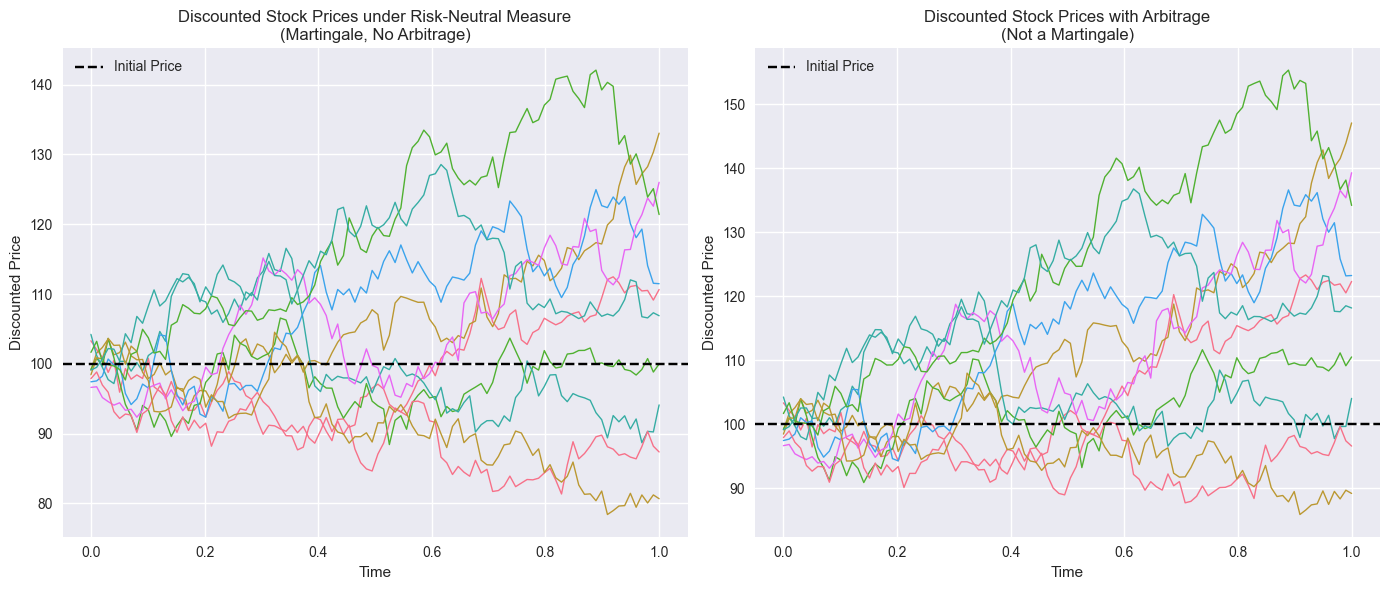

In [14]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

# Time and simulation setup
T = 1.0
N = 100
dt = T / N
t = np.linspace(0, T, N)
n_paths = 10

# Parameters
S0 = 100
r = 0.05
sigma = 0.2

# Risk-neutral GBM (martingale in discounted terms)
Z_rn = np.random.normal(0, 1, size=(n_paths, N))
W_rn = np.cumsum(np.sqrt(dt) * Z_rn, axis=1)
S_rn = S0 * np.exp((r - 0.5 * sigma**2) * t + sigma * W_rn)
S_rn_discounted = S_rn * np.exp(-r * t)

# Non-martingale case: with arbitrage (wrong drift)
fake_drift = 0.15  # greater than risk-free rate
S_arbitrage = S0 * np.exp((fake_drift - 0.5 * sigma**2) * t + sigma * W_rn)
S_arbitrage_discounted = S_arbitrage * np.exp(-r * t)

# Plotting
plt.figure(figsize=(14, 6))

# Martingale case
plt.subplot(1, 2, 1)
for i in range(n_paths):
    plt.plot(t, S_rn_discounted[i], lw=1)
plt.axhline(S0, color='black', linestyle='--', label="Initial Price")
plt.title("Discounted Stock Prices under Risk-Neutral Measure\n(Martingale, No Arbitrage)")
plt.xlabel("Time")
plt.ylabel("Discounted Price")
plt.legend()
plt.grid(True)

# Arbitrage case
plt.subplot(1, 2, 2)
for i in range(n_paths):
    plt.plot(t, S_arbitrage_discounted[i], lw=1)
plt.axhline(S0, color='black', linestyle='--', label="Initial Price")
plt.title("Discounted Stock Prices with Arbitrage\n(Not a Martingale)")
plt.xlabel("Time")
plt.ylabel("Discounted Price")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
